In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy import stats

data = pd.read_csv("data/Train.csv")
data.head()

ID District      Block  CultLand  CropCultLand  \
0  ID_GTFAC7PEVWQ9  Nalanda  Noorsarai        45            40   
1  ID_TK40ARLSPOKS  Nalanda     Rajgir        26            26   
2  ID_1FJY2CRIMLZZ     Gaya      Gurua        10            10   
3  ID_I3IPXS4DB7NE     Gaya      Gurua        15            15   
4  ID_4T8YQWXWHB4A  Nalanda  Noorsarai        60            60   

                               LandPreparationMethod CropTillageDate  \
0               TractorPlough FourWheelTracRotavator      2022-07-20   
1  WetTillagePuddling TractorPlough FourWheelTrac...      2022-07-18   
2               TractorPlough FourWheelTracRotavator      2022-06-30   
3               TractorPlough FourWheelTracRotavator      2022-06-16   
4                   TractorPlough WetTillagePuddling      2022-07-19   

   CropTillageDepth         CropEstMethod RcNursEstDate  ... Harv_method  \
0                 5  Manual_PuddledRandom    2022-06-27  ...     machine   
1                 5  Manual_PuddledRandom    2022-06-20  ...        hand   
2                 6  Manual_PuddledRandom    2022-06-20  ...        hand   
3                 6  Manual_PuddledRandom    2022-06-17  ...        hand   
4                 4  Manual_PuddledRandom    2022-06-21  ...     machine   

    Harv_date Harv_hand_rent Threshing_date  Threshing_method Residue_length  \
0  2022-11-16            NaN     2022-11-16           machine             30   
1  2022-11-25            3.0     2022-12-24           machine             24   
2  2022-12-12          480.0     2023-01-11           machine             30   
3  2022-12-02          240.0     2022-12-29              hand             26   
4  2022-11-30            NaN     2022-12-02           machine             24   

  Residue_perc     Stubble_use      Acre Yield  
0           40  plowed_in_soil  0.312500   600  
1           10  plowed_in_soil  0.312500   600  
2           10  plowed_in_soil  0.148148   225  
3           10  plowed_in_soil  0.222222   468  
4           40  plowed_in_soil  0.468750   550  

[5 rows x 44 columns]

In [2]:
y = data['Yield']
X = data.drop(['Yield', 'ID'], axis=1)

## Начнем с базового препроцессинга

In [3]:
for feature in X.select_dtypes(include=[np.number]).columns:
        median_value = X[feature].median() 
        X[feature] = X[feature].fillna(median_value)

Plotting distributions for each feature...


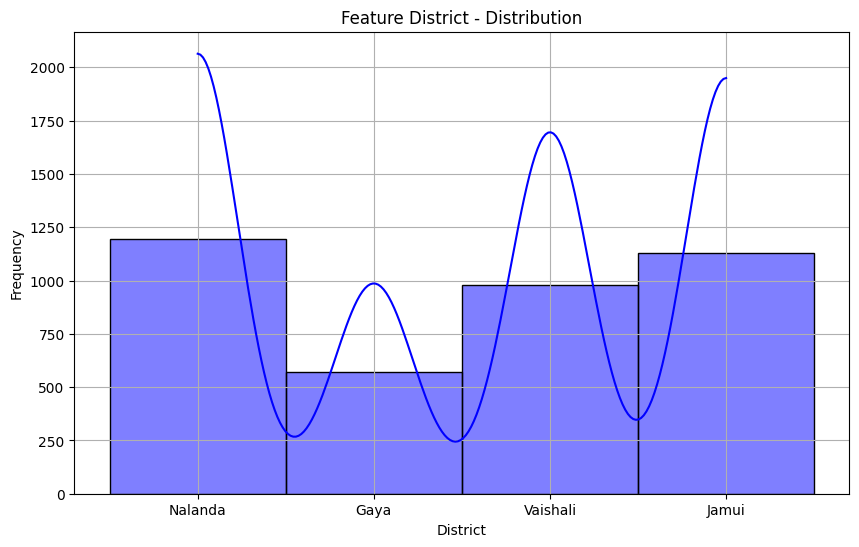

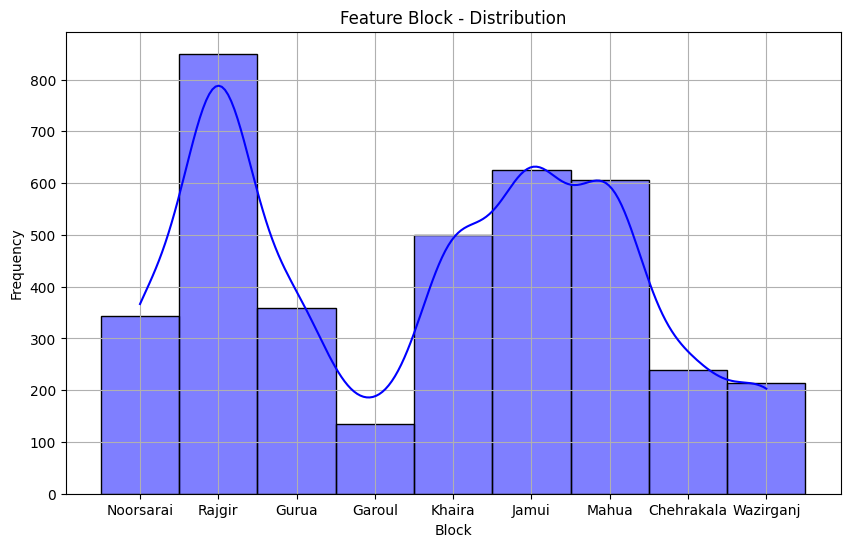

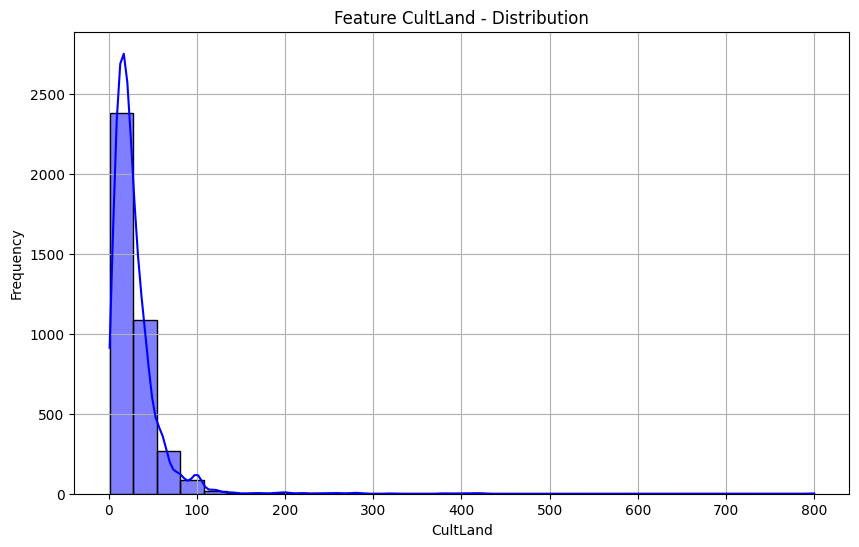

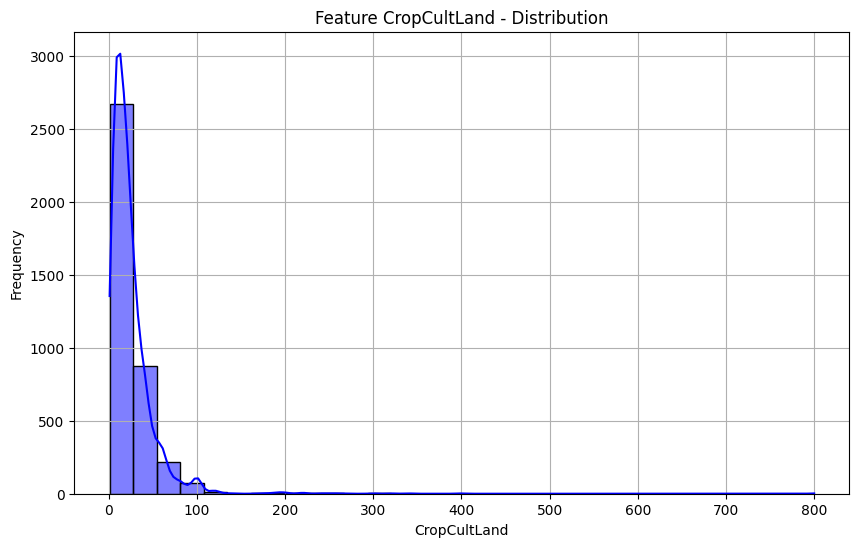

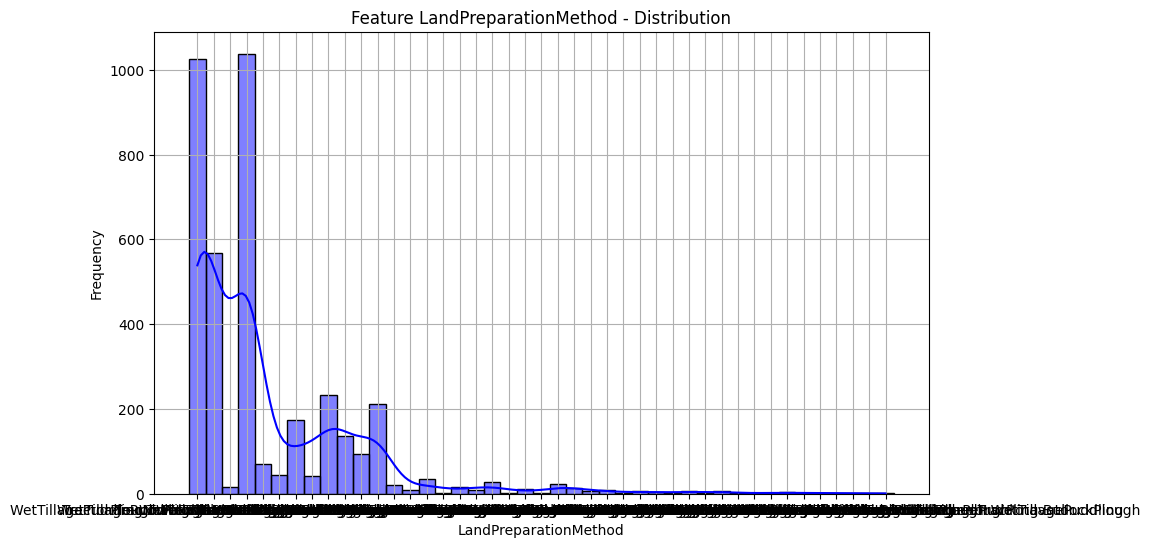

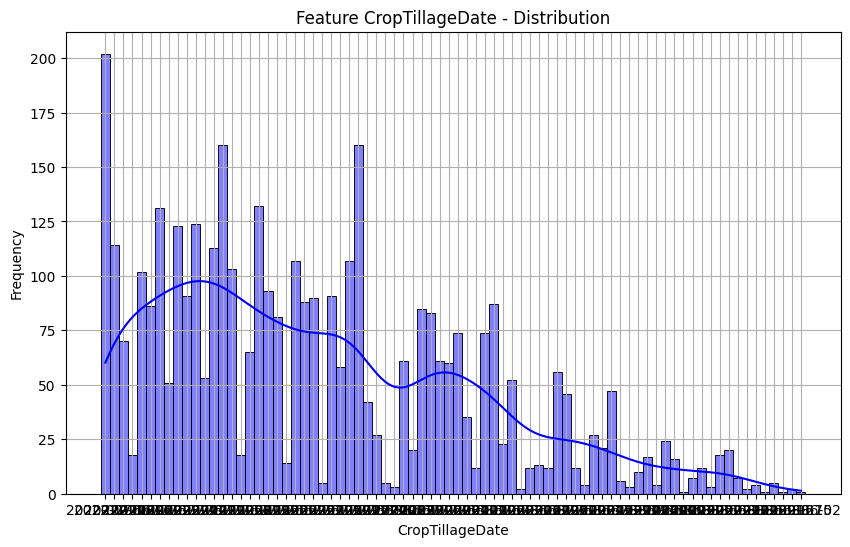

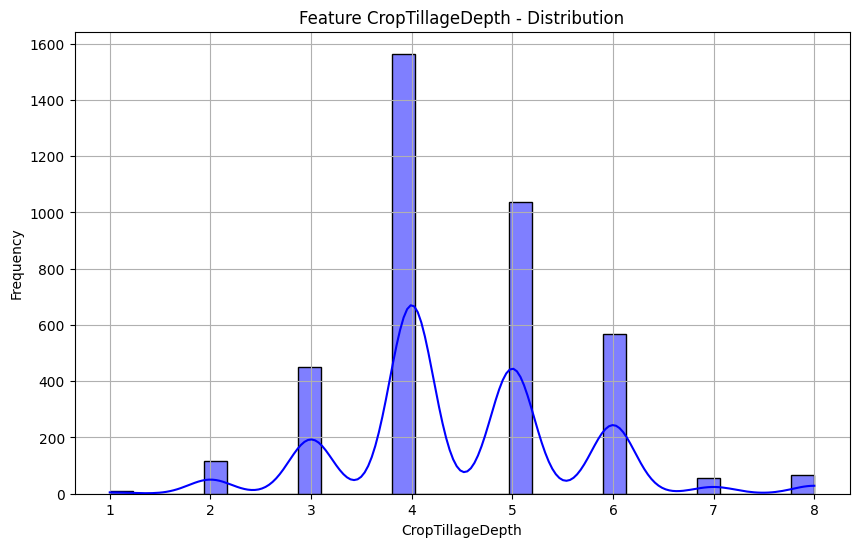

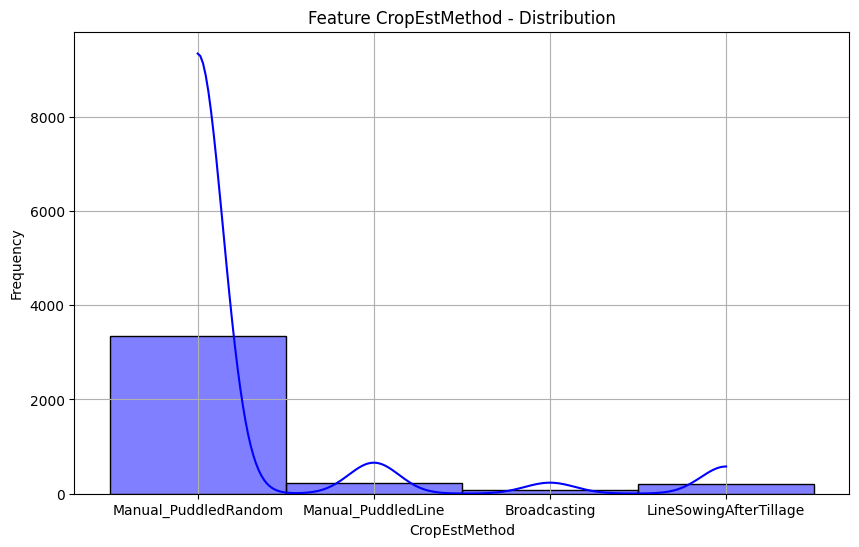

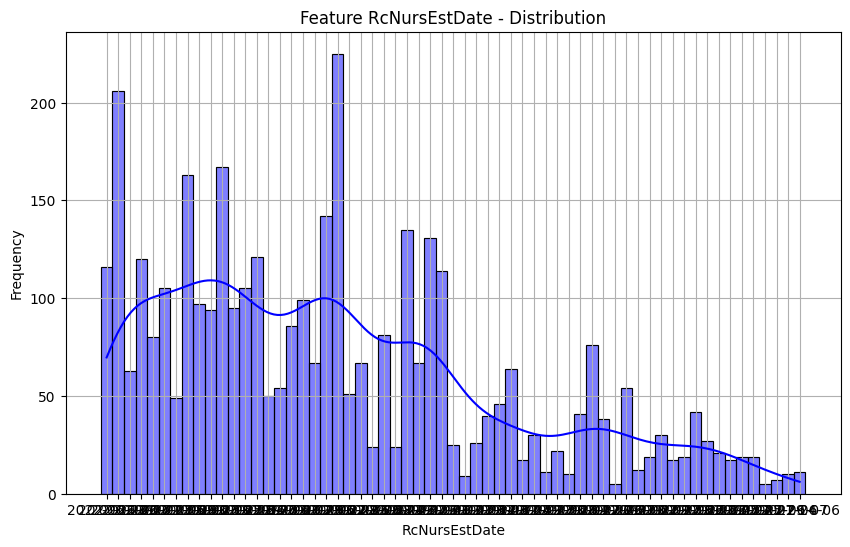

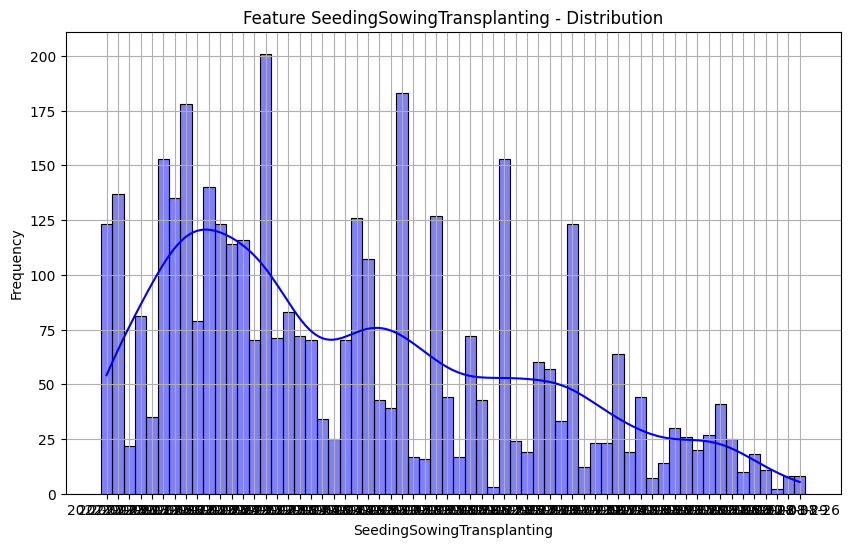

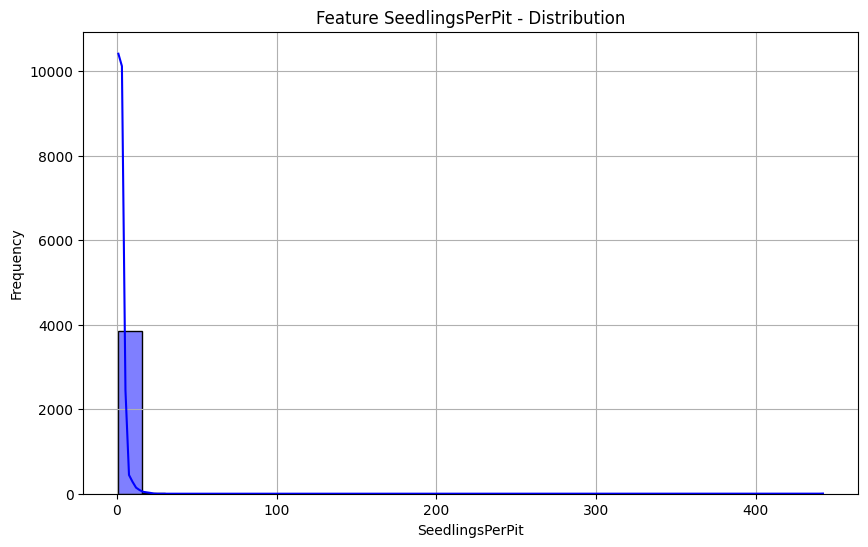

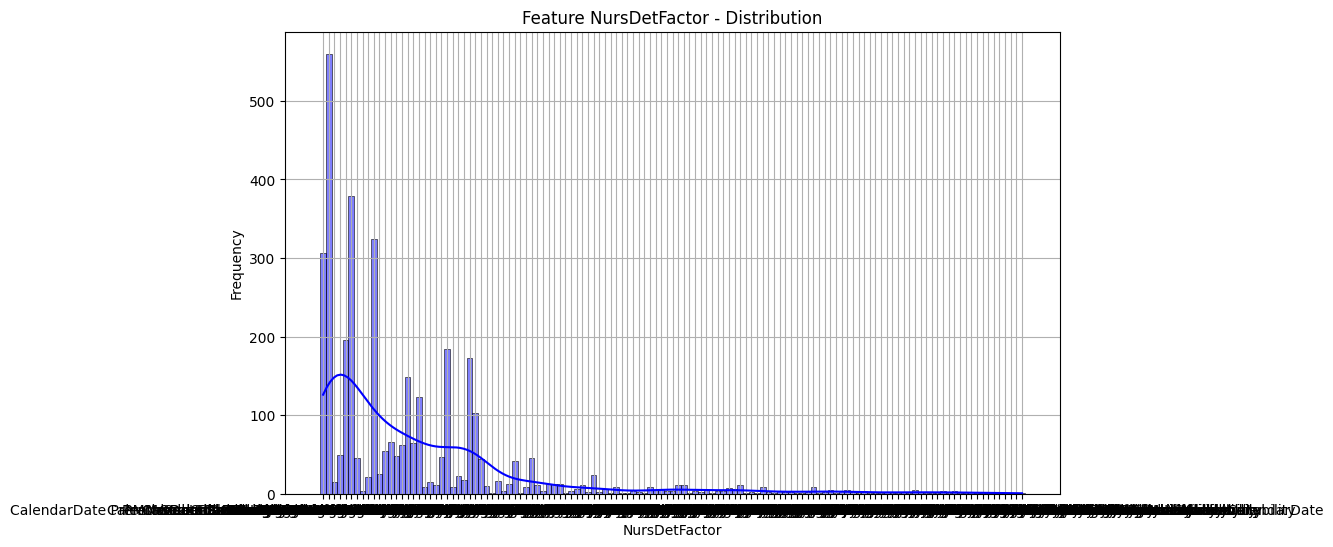

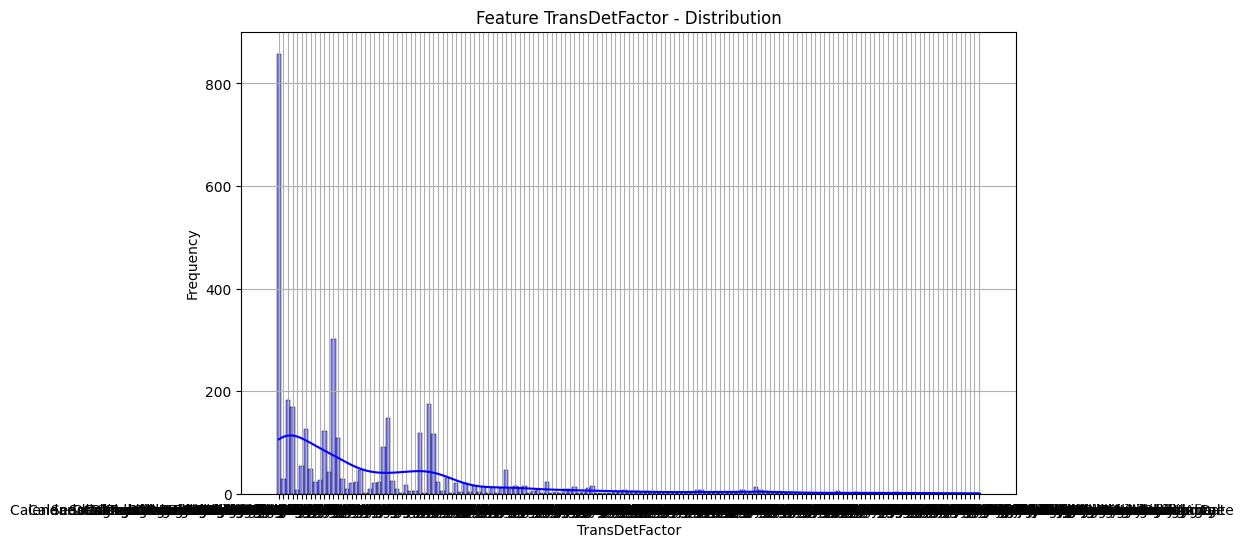

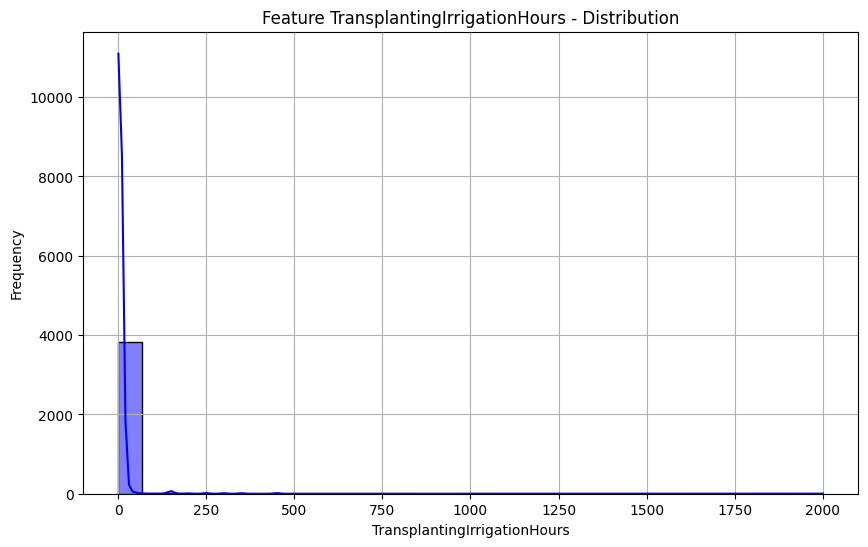

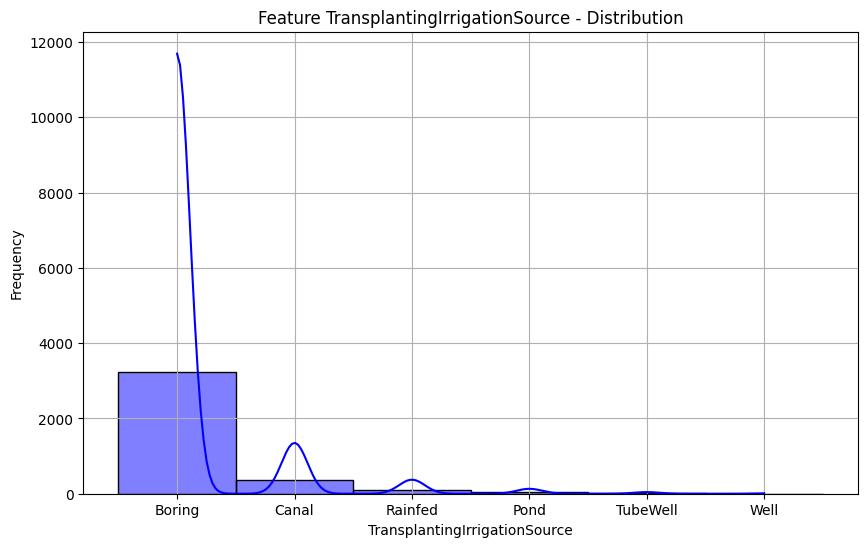

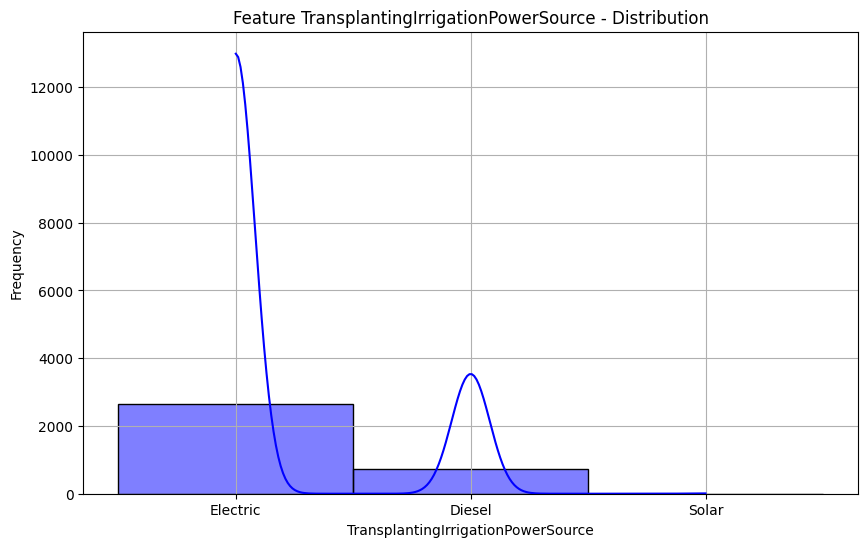

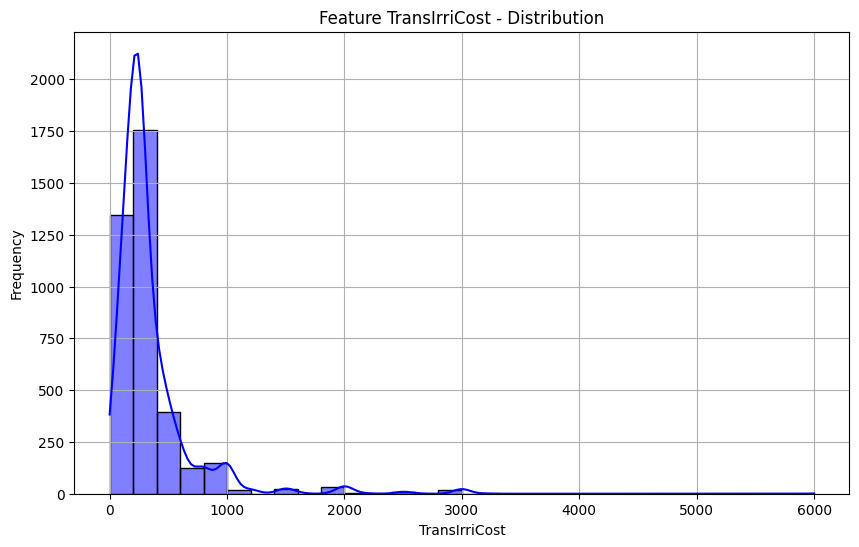

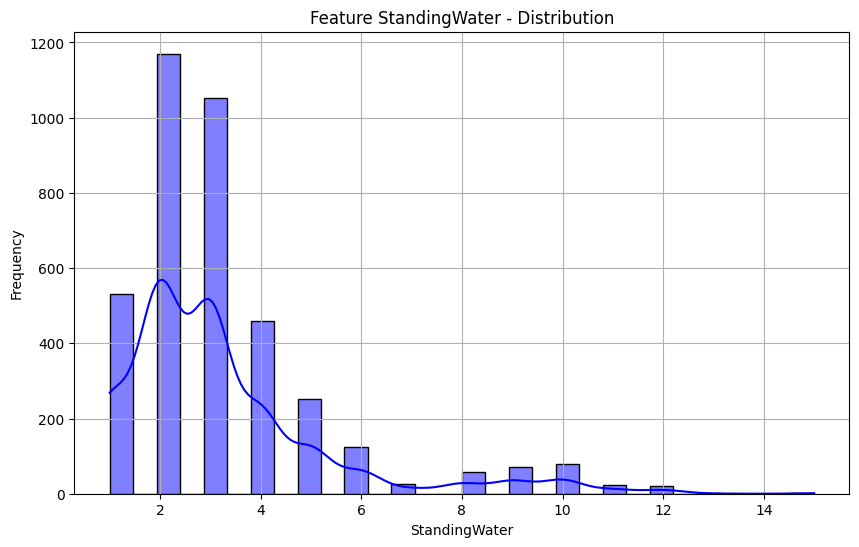

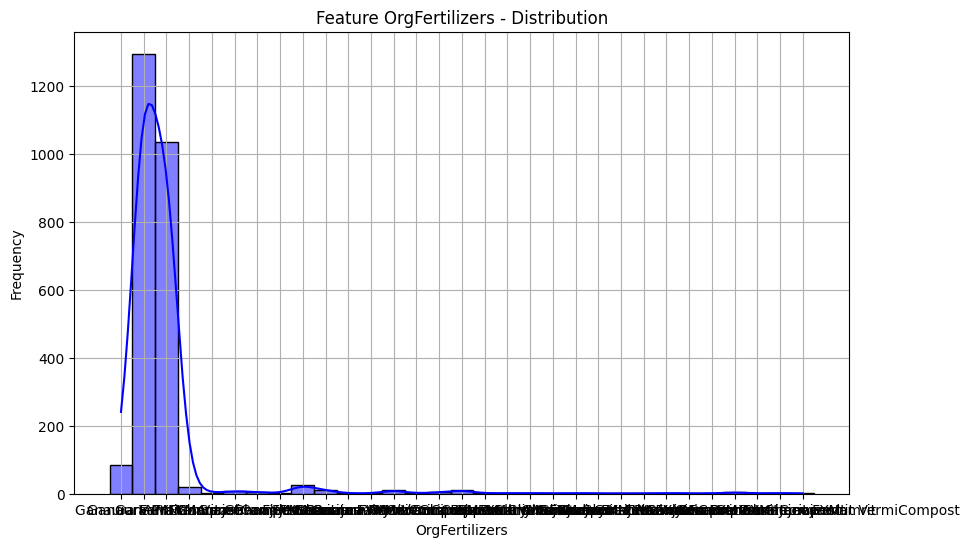

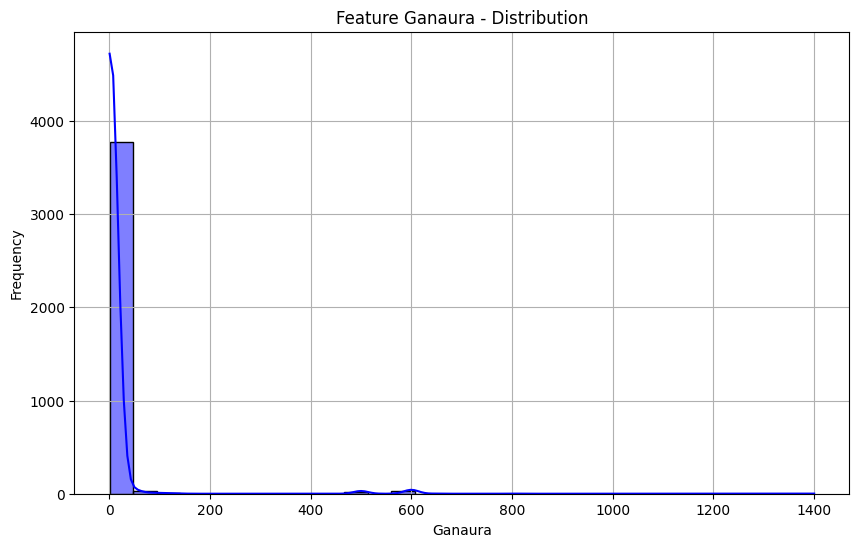

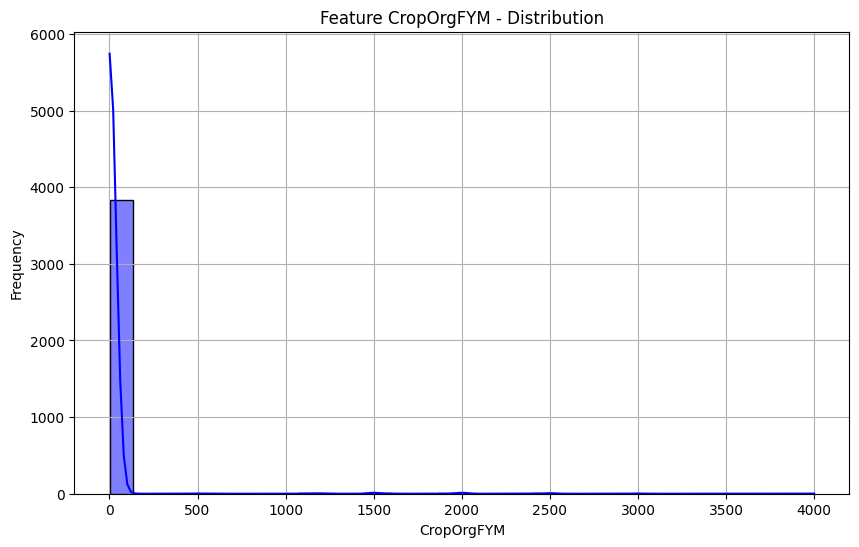

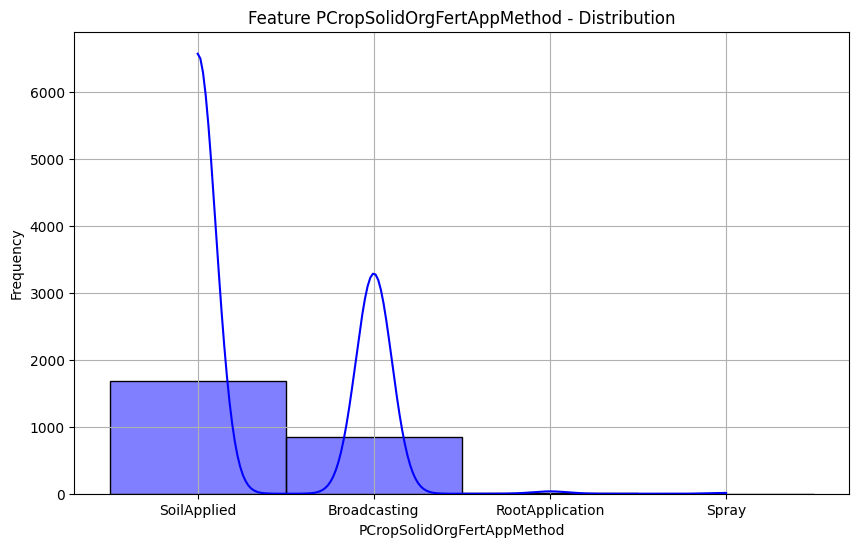

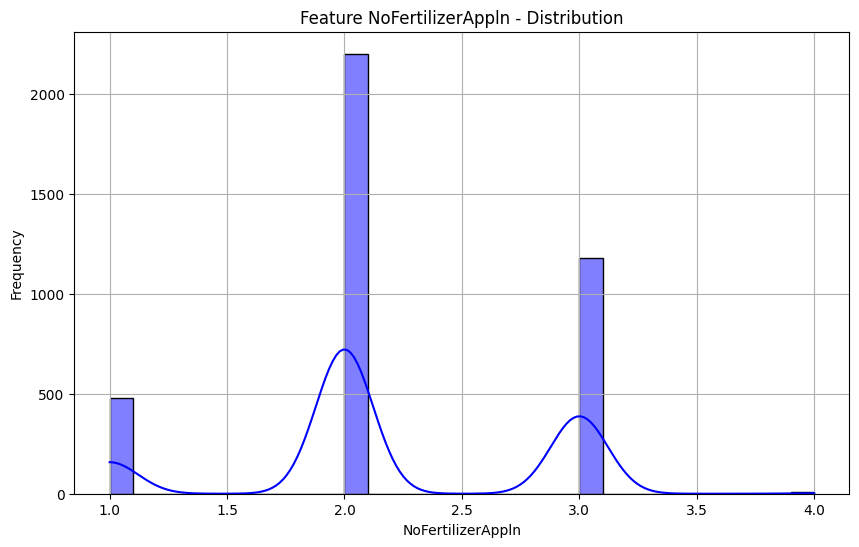

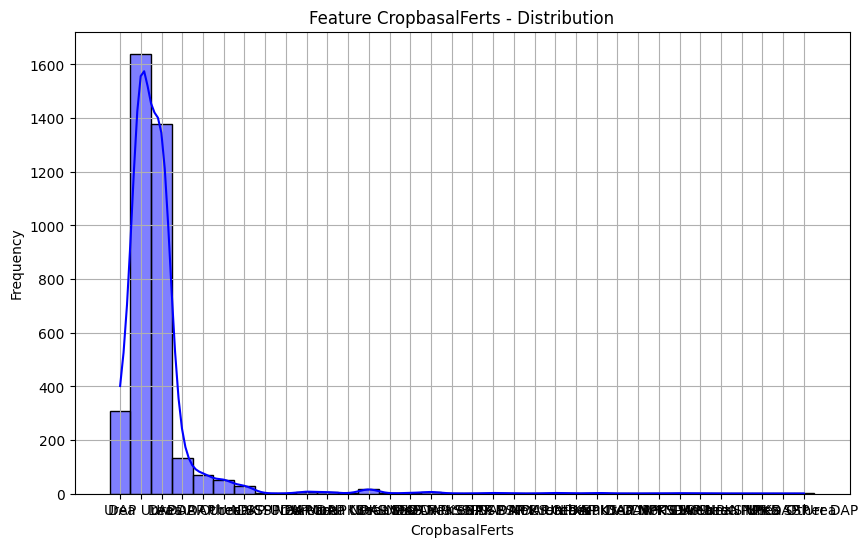

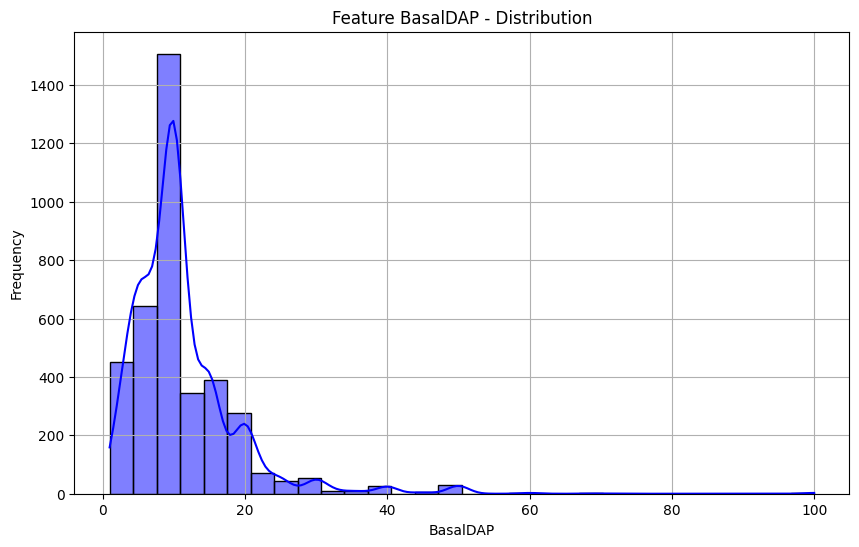

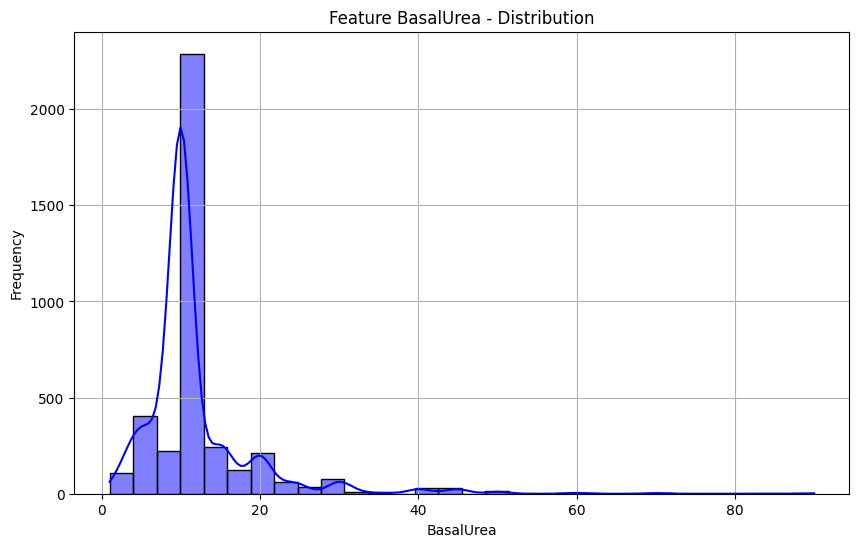

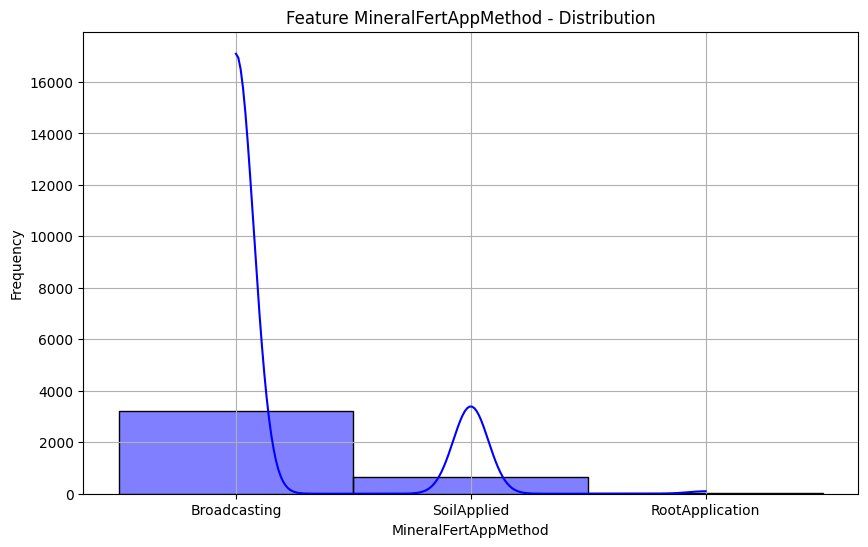

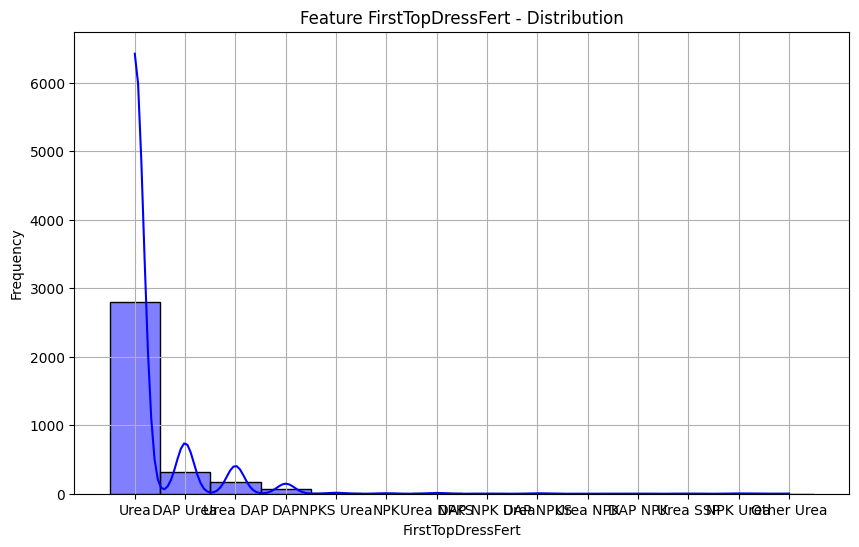

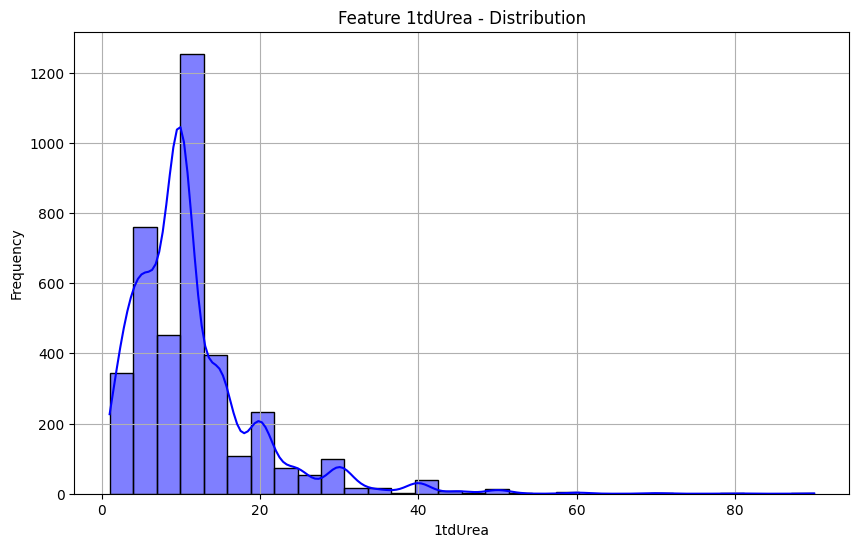

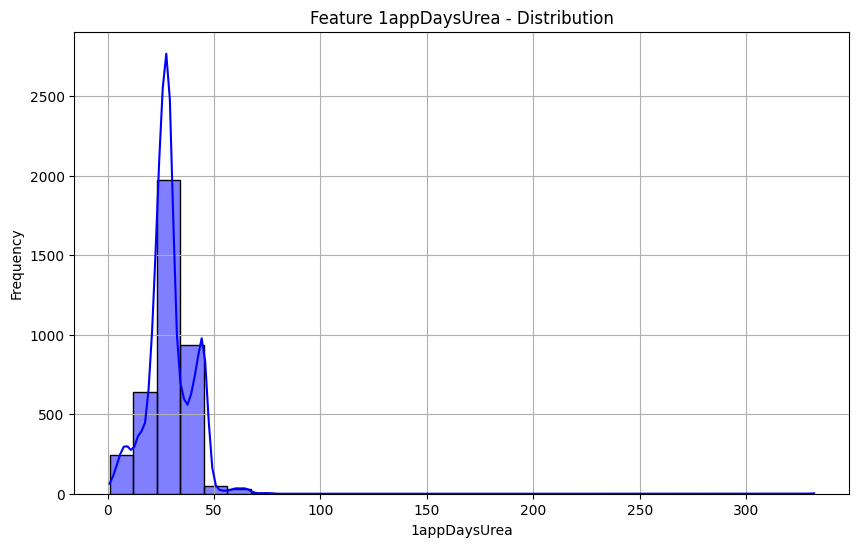

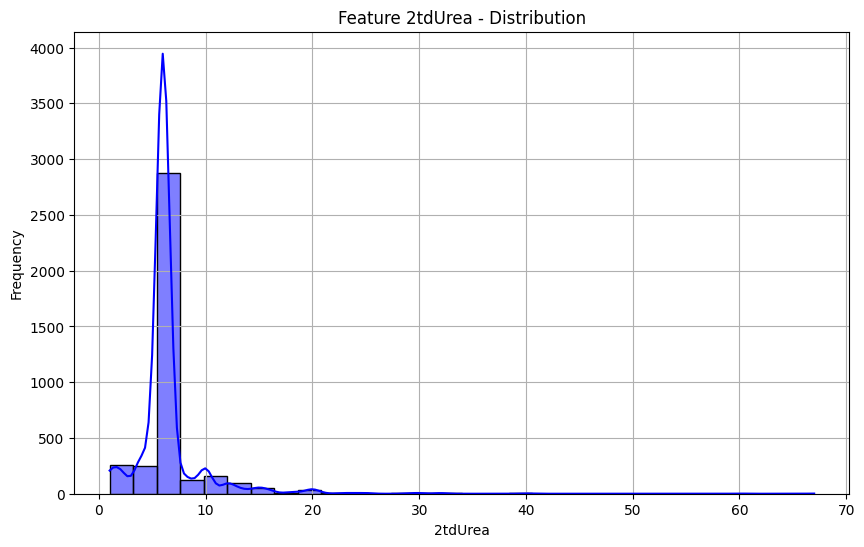

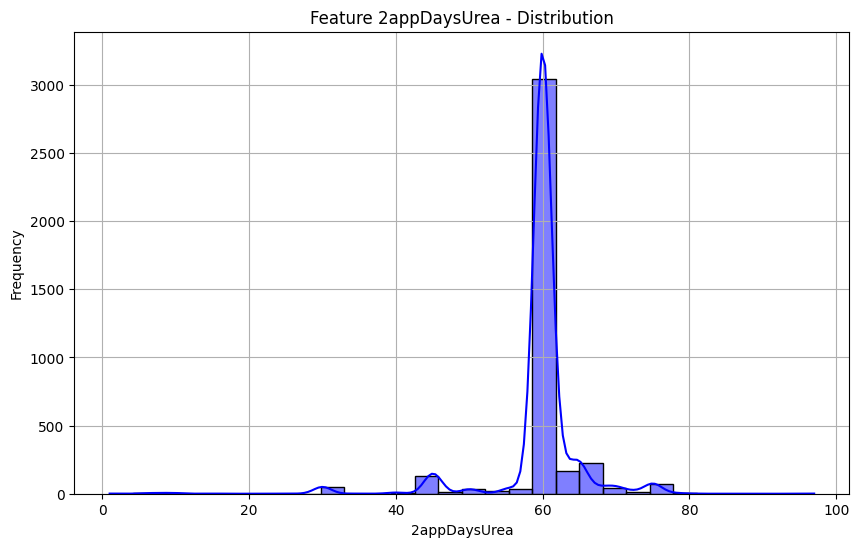

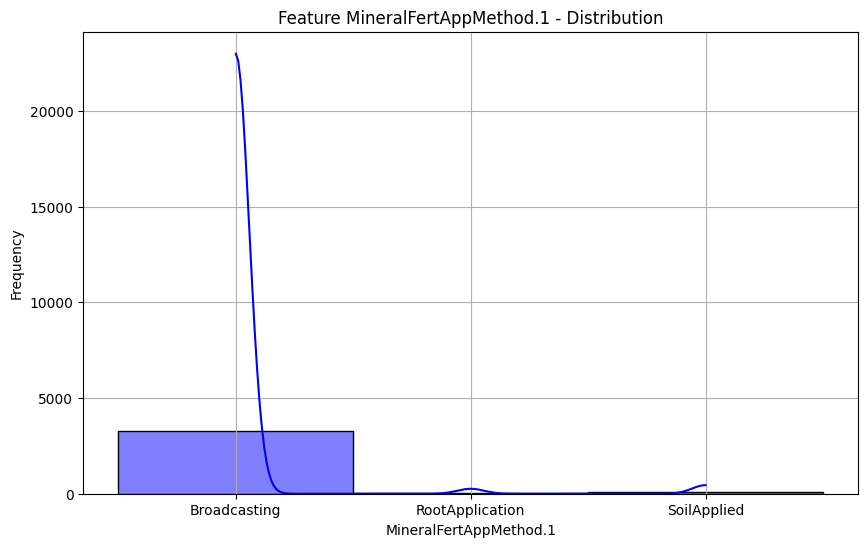

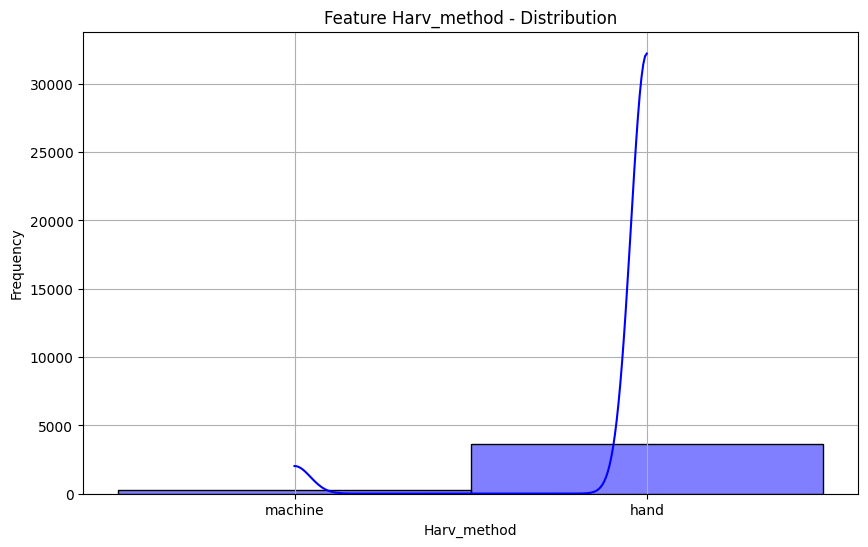

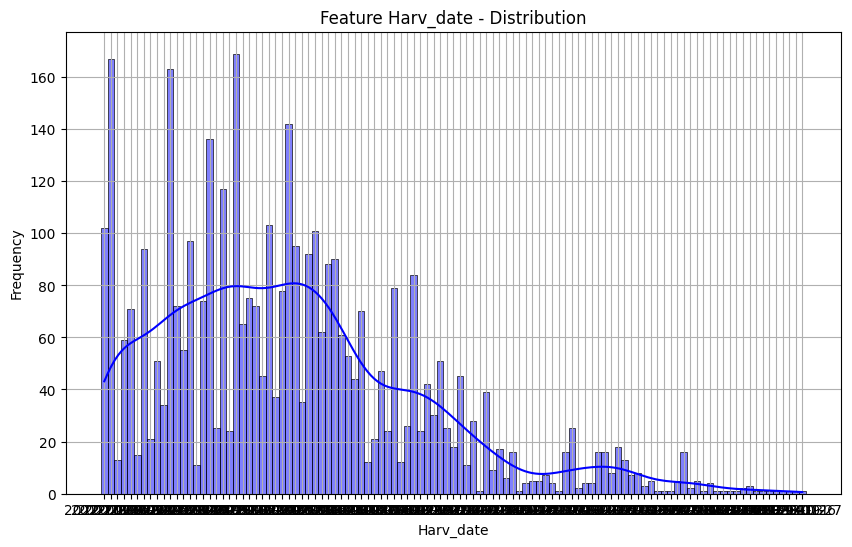

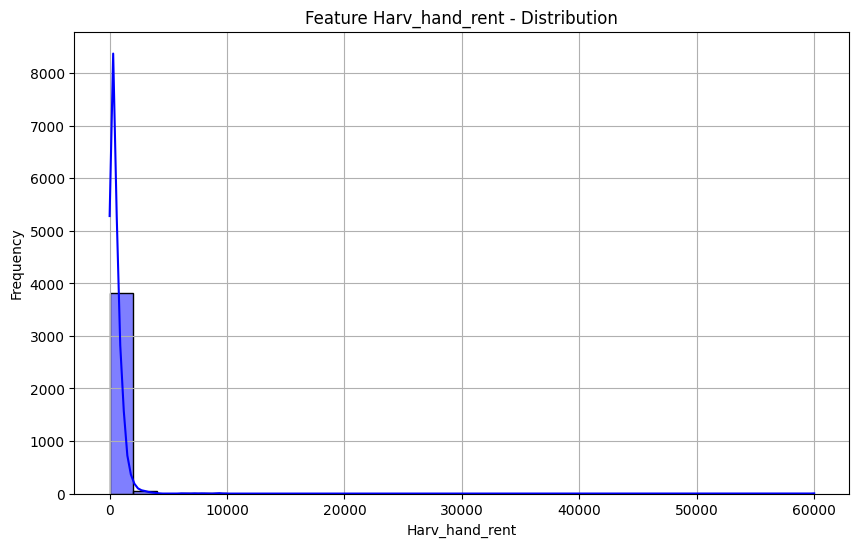

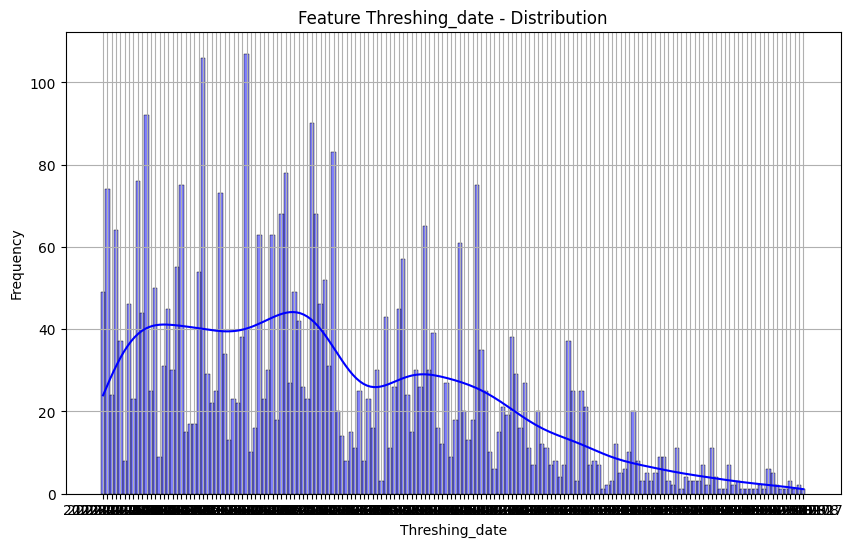

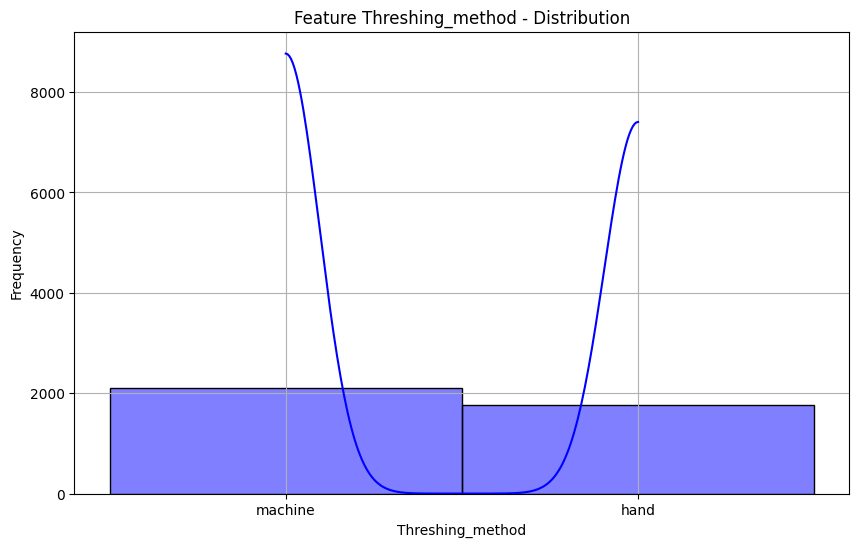

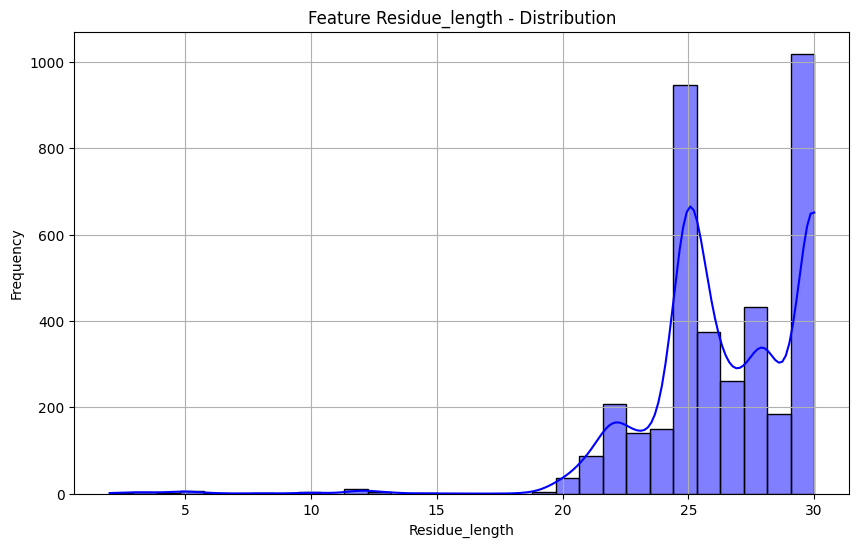

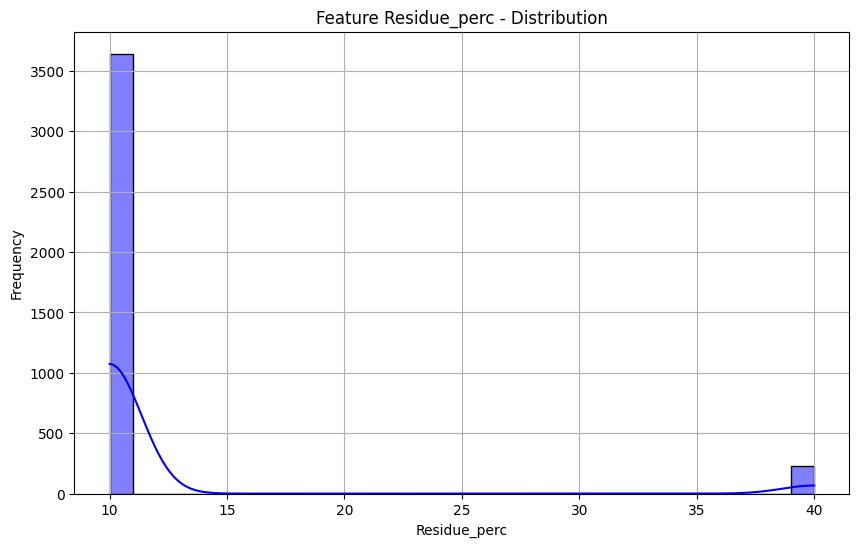

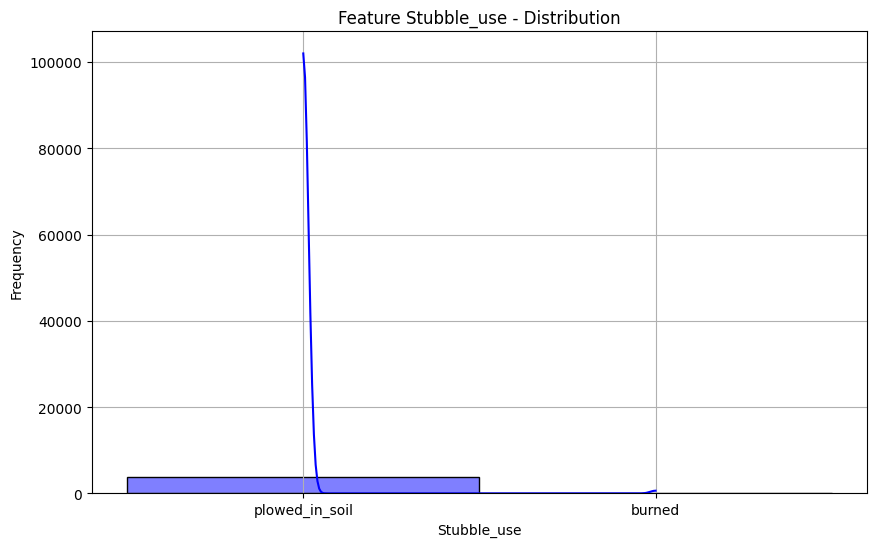

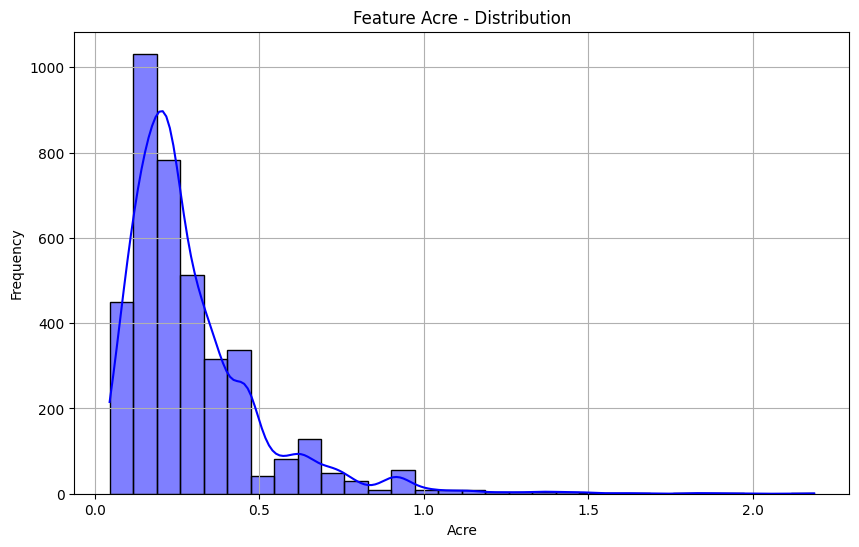

Plotting correlation matrix...


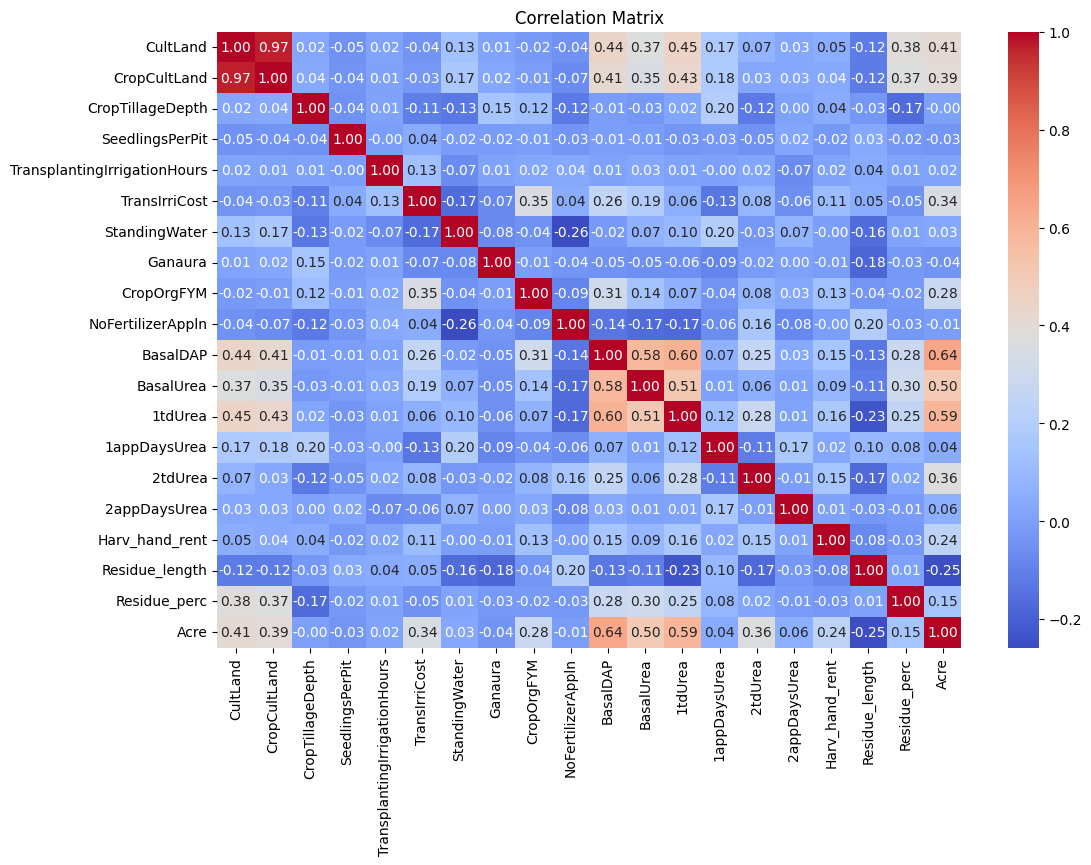

In [4]:
def analyze_distributions_and_correlation(data, title_prefix="Feature"):
    """
    Analyzes the distribution and correlation of features in a dataset.
    
    Parameters:
    - data: pd.DataFrame - The dataset to analyze (features only, no target).
    - title_prefix: str - Prefix for the plot titles.
    
    Returns:
    - None
    """
    # Plot distributions
    print("Plotting distributions for each feature...")
    for column in data.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(data[column], kde=True, bins=30, color="blue")
        plt.title(f"{title_prefix} {column} - Distribution")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.grid()
        plt.show()

    # Plot correlation matrix
    print("Plotting correlation matrix...")
    correlation_matrix = data[data.select_dtypes(include=[np.number]).columns].corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix")
    plt.show()

    return correlation_matrix

correlation_matrix = analyze_distributions_and_correlation(X)


In [5]:
train_data, test_data, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
train_data, val_data, y_train, y_val = train_test_split(train_data, y_train, test_size=2./9, random_state=42) 

In [6]:
from sklearn.model_selection import train_test_split

train_data, test_data, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
train_data, val_data, y_train, y_val = train_test_split(train_data, y_train, test_size=2./9, random_state=42) 

train_reduced = train_data.select_dtypes(include=['number'])
val_reduced = val_data.select_dtypes(include=['number'])
test_reduced = test_data.select_dtypes(include=['number'])

train = train_data
val = val_data
test = test_data

### Модель

In [7]:
import numpy as np

class LinearRegressionElasticNet:
    def __init__(self, epsilon=1e-6, max_steps=10000, w0=None, b0=None, alpha=1e-5, l1_ratio=0.5, lam=1e-2):
        self.epsilon = epsilon
        self.max_steps = max_steps
        self.w0 = w0
        self.alpha = alpha  
        self.l1_ratio = l1_ratio  
        self.lam = lam  
        self.w = None
        self.b0 = b0
        self.b = None
        
    def fit(self, X, y):
        X = self._scale_features(X)
        y = self._scale_target(y)

        l, d = X.shape

        if self.w0 is None:
            self.w0 = np.zeros(d)
        self.w = self.w0.copy()

        if self.b0 is None:
            self.b0 = 0.0
        self.b = self.b0

        for step in range(self.max_steps):
            y_pred = np.dot(X, self.w) + self.b
            residuals = y_pred - y

            grad_loss_w = (2 / l) * np.dot(X.T, residuals)
            grad_reg_w = self.lam * (self.l1_ratio * np.sign(self.w) + (1 - self.l1_ratio) * self.w)
            gradient_w = grad_loss_w + grad_reg_w
            gradient_w = np.clip(gradient_w, -1e5, 1e5)
            if np.isnan(gradient_w).any():
                raise ValueError("NaN detected in gradients. Try reducing the learning rate.")

            gradient_b = (2 / l) * np.sum(residuals)
            w_new = self.w - self.alpha * gradient_w
            b_new = self.b - self.alpha * gradient_b

            if np.linalg.norm(w_new - self.w) < self.epsilon:
                self.w = w_new
                self.b = b_new
                break
                
            self.w = w_new
            self.b = b_new

        self.X_mean = self.X_mean_
        self.X_std = self.X_std_
        self.y_mean = self.y_mean_
        self.y_std = self.y_std_

        return self
    
    def predict(self, X):
        if self.w is None or self.b is None:
            raise Exception('Model has not been trained yet')
        
        X_scaled = (X - self.X_mean) / self.X_std
        y_pred_scaled = np.dot(X_scaled, self.w) + self.b
        return y_pred_scaled * self.y_std + self.y_mean

    def get_b(self):
        return self.b * self.y_std + self.y_mean - np.dot(self.X_mean / self.X_std, self.w * self.y_std)

    def _scale_features(self, X):
        self.X_mean_ = np.mean(X, axis=0)
        self.X_std_ = np.std(X, axis=0)
        self.X_std_[self.X_std_ == 0] = 1.0
        return (X - self.X_mean_) / self.X_std_

    def _scale_target(self, y):
        self.y_mean_ = np.mean(y)
        self.y_std_ = np.std(y)
        if self.y_std_ == 0:
            self.y_std_ = 1.0
        return (y - self.y_mean_) / self.y_std_


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_report(y_true, y_pred):
    report = {
        'Metric': ['MAE', 'MSE', 'RMSE', 'R²', 'MAPE'],
        'Value': [
            mean_absolute_error(y_true, y_pred),
            mean_squared_error(y_true, y_pred),
            mean_squared_error(y_true, y_pred, squared=False),
            r2_score(y_true, y_pred),
            np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        ]
    }
    return pd.DataFrame(report)

In [8]:
custom_model = LinearRegressionElasticNet(
    max_steps=10000,
    alpha=1e-3,      
    l1_ratio=0.005,  
    lam=1e-2        
)

custom_model.fit(train_reduced, y_train)


In [9]:
y_pred = custom_model.predict(test_reduced)
report_df = regression_report(y_test, y_pred)
report_df

c:\Users\edimv\Desktop\MOMO\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metric          Value
0    MAE     181.224639
1    MSE  649246.786621
2   RMSE     805.758516
3     R²       0.283927
4   MAPE     147.520880

## Поработаем с признаками

In [10]:
train = train_reduced
val = val_reduced
test = test_reduced

Уберем выбросы

In [ ]:
all_data = pd.concat([train, val, test], axis=0)  # Объединяем все данные

# Преобразуем названия колонок в строки
all_data.columns = all_data.columns.astype(str)
indices_to_keep = all_data.index
for feature in all_data.select_dtypes(include=[np.number]).columns:
    Q1 = all_data[feature].quantile(0.01)
    Q3 = all_data[feature].quantile(0.99)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Оставляем только индексы строк, удовлетворяющих условиям
    valid_indices = all_data[(all_data[feature] >= lower_bound) & (all_data[feature] <= upper_bound)].index
    indices_to_keep = indices_to_keep.intersection(valid_indices)

# Фильтруем train и y_train по индексам
all_data = all_data.loc[indices_to_keep]
y = y.loc[indices_to_keep]

# Сбрасываем индексы для train и y_train
all_data = all_data.reset_index(drop=True)
y = y.reset_index(drop=True)

Нормализация

In [ ]:

scaler_type = 'standard'
if scaler_type == 'standard':
    scaler = StandardScaler()
elif scaler_type == 'minmax':
    scaler = MinMaxScaler()
else:
    raise ValueError("Scaler type must be 'standard' or 'minmax'")
all_data_scaled = pd.DataFrame(scaler.fit_transform(all_data), columns=all_data.columns)


Описательная статистика

In [13]:
def descriptive_statistics(data):
    """
    Calculates and returns descriptive statistics for each feature in the dataset.

    Parameters:
    - data: pd.DataFrame - The dataset to analyze (features only, no target).

    Returns:
    - pd.DataFrame - Descriptive statistics including mean, median, std, range, quartiles, skewness, and kurtosis.
    """
    stats = pd.DataFrame(index=data.columns)

    stats['Mean'] = data.mean()
    stats['Median'] = data.median()
    stats['Std Dev'] = data.std()
    stats['Range'] = data.max() - data.min()
    stats['25th Percentile'] = data.quantile(0.25)
    stats['50th Percentile (Median)'] = data.quantile(0.50)
    stats['75th Percentile'] = data.quantile(0.75)
    stats['Skewness'] = data.skew()
    stats['Kurtosis'] = data.kurt()

    return stats

descriptive_stats = descriptive_statistics(all_data_scaled)

descriptive_stats

Mean    Median   Std Dev      Range  \
CultLand                     -7.432455e-18 -0.311548  1.000131  16.149445   
CropCultLand                 -3.158794e-17 -0.184523  1.000131  14.394236   
CropTillageDepth             -2.201865e-16 -0.423208  1.000131   6.183644   
SeedlingsPerPit              -9.290569e-17 -0.273737  1.000131  10.553136   
TransplantingIrrigationHours -1.300680e-17 -0.124444  1.000131  20.038254   
TransIrriCost                -3.112341e-17 -0.258425  1.000131  16.846611   
StandingWater                -4.459473e-17 -0.112596  1.000131   6.523764   
Ganaura                       1.858114e-18 -0.133337  1.000131  16.346999   
CropOrgFYM                    1.858114e-17 -0.059413  1.000131  26.247523   
NoFertilizerAppln            -3.781262e-16 -0.296336  1.000131   4.734777   
BasalDAP                     -7.014380e-17 -0.147405  1.000131  13.277214   
BasalUrea                    -1.114868e-17 -0.247103  1.000131  12.027739   
1tdUrea                      -2.601359e-17 -0.155482  1.000131  11.058785   
1appDaysUrea                 -7.804078e-17 -0.095454  1.000131   7.298360   
2tdUrea                      -1.068415e-16 -0.126214  1.000131  12.684017   
2appDaysUrea                  4.087850e-17  0.059741  1.000131  15.293633   
Harv_hand_rent               -1.300680e-17 -0.205010  1.000131  13.055387   
Residue_length               -5.481436e-16 -0.177522  1.000131   9.025443   
Residue_perc                 -1.154353e-16 -0.250035  1.000131   4.249479   
Acre                          1.012672e-16 -0.307592  1.000131  10.585566   

                              25th Percentile  50th Percentile (Median)  \
CultLand                            -0.619890                 -0.311548   
CropCultLand                        -0.609131                 -0.184523   
CropTillageDepth                    -0.423208                 -0.423208   
SeedlingsPerPit                     -0.273737                 -0.273737   
TransplantingIrrigationHours        -0.213702                 -0.124444   
TransIrriCost                       -0.455002                 -0.258425   
StandingWater                       -0.578580                 -0.112596   
Ganaura                             -0.133337                 -0.133337   
CropOrgFYM                          -0.059413                 -0.059413   
NoFertilizerAppln                   -0.296336                 -0.296336   
BasalDAP                            -0.683858                 -0.147405   
BasalUrea                           -0.247103                 -0.247103   
1tdUrea                             -0.652507                 -0.155482   
1appDaysUrea                        -0.391334                 -0.095454   
2tdUrea                             -0.126214                 -0.126214   
2appDaysUrea                         0.059741                  0.059741   
Harv_hand_rent                      -0.736927                 -0.205010   
Residue_length                      -0.499859                 -0.177522   
Residue_perc                        -0.250035                 -0.250035   
Acre                                -0.658573                 -0.307592   

                              75th Percentile   Skewness    Kurtosis  
CultLand                             0.266595   4.271571   35.482322  
CropCultLand                         0.240086   3.670974   25.447672  
CropTillageDepth                     0.460170   0.355375    0.768422  
SeedlingsPerPit                      0.228793   3.981621   22.664700  
TransplantingIrrigationHours        -0.079816  11.635830  155.846671  
TransIrriCost                        0.162810   4.783003   36.877080  
StandingWater                        0.353387   1.920072    4.145854  
Ganaura                             -0.133337   8.266444   72.781382  
CropOrgFYM                          -0.059413  19.768003  405.227638  
NoFertilizerAppln                    1.281923  -0.133761   -0.529301  
BasalDAP                             0.254934   3.009738   17.9

Признаки с наибольшим размахом:
CropOrgFYM (26.24): Может свидетельствовать о широком разбросе данных или наличии выбросов.
TransIrriCost (16.85) и CultLand (16.14): Имеют большие значения размаха, что может потребовать дополнительного анализа.
Признаки с меньшим размахом:
NoFertilizerAppln (4.73): Указывает на сравнительно небольшую вариативность в данных.
  
Разброс между 25% и 75% перцентилем (межквартильный размах, IQR) показывает плотность данных.
StandingWater, BasalDAP, и CropOrgFYM имеют большой IQR, что свидетельствует о значительной концентрации данных в среднем диапазоне.
Некоторые признаки, например, Residue_perc, имеют меньший IQR, что говорит о большей схожести данных.  

Положительная асимметрия (Skewness > 0):
TransplantingIrrigationHours (11.64): Указывает на длинный правый хвост в распределении.
CropOrgFYM (19.76): Имеет высокую положительную асимметрию, что указывает на сильное смещение вправо.
Отрицательная асимметрия (Skewness < 0):
NoFertilizerAppln (-0.13): Лёгкое смещение влево.
Признаки с высокой асимметрией требуют логарифмического преобразования или другого метода для нормализации.  

Высокий эксцесс (>3):
CropOrgFYM (405.23) и TransplantingIrrigationHours (155.84): Указывают на узкий пик с длинными хвостами, что может быть следствием выбросов.
Низкий эксцесс (<3):
NoFertilizerAppln (-0.52): Указывает на более плоское распределение.



Plotting distributions for each feature...


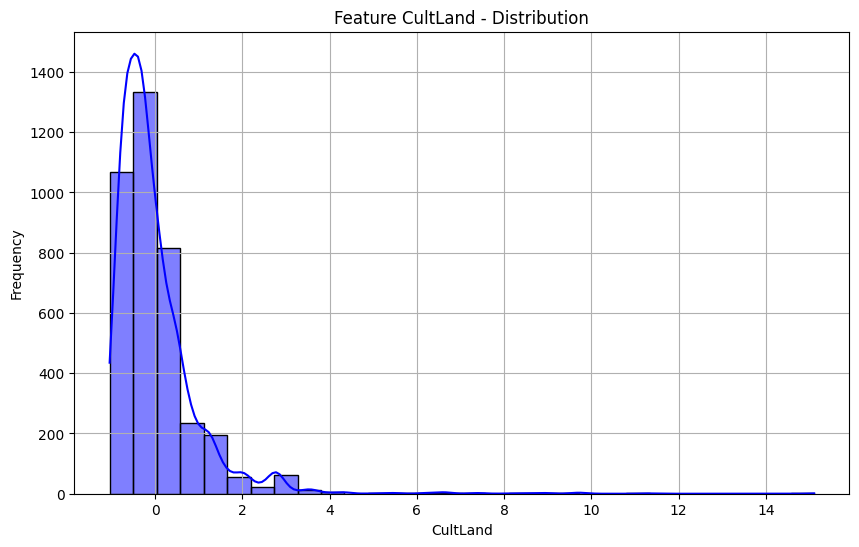

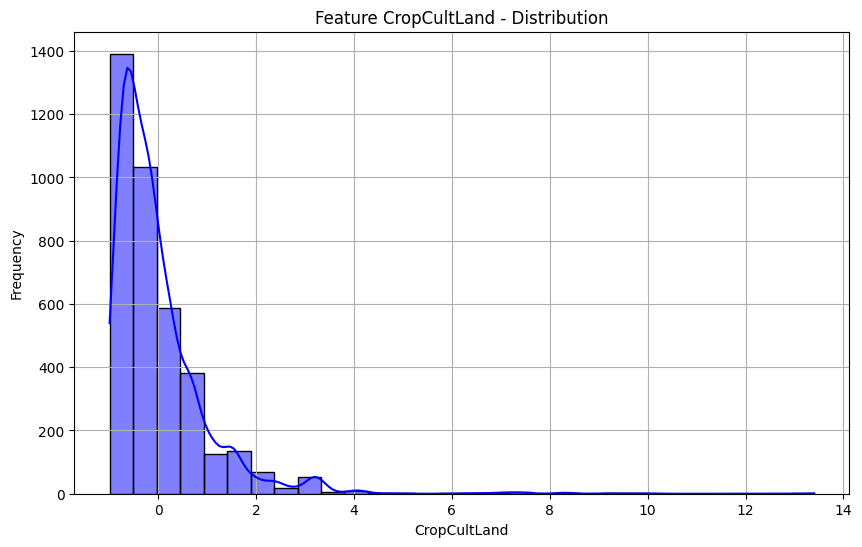

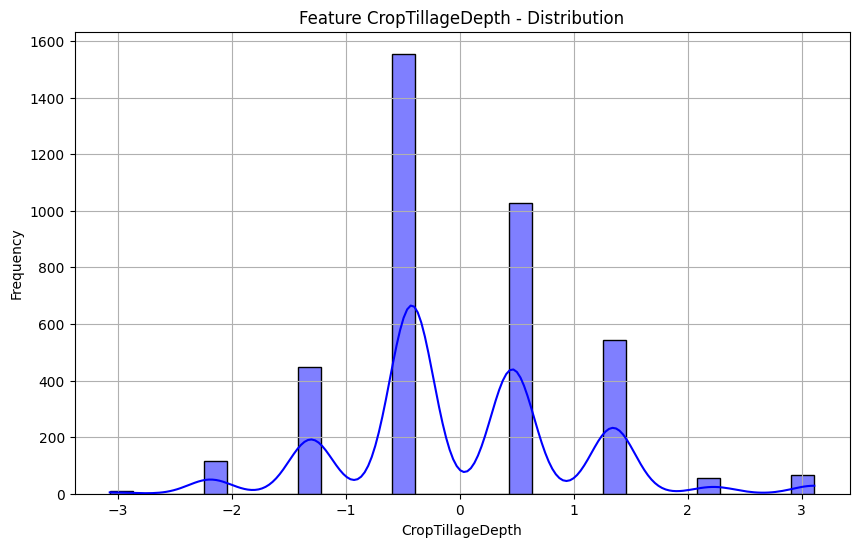

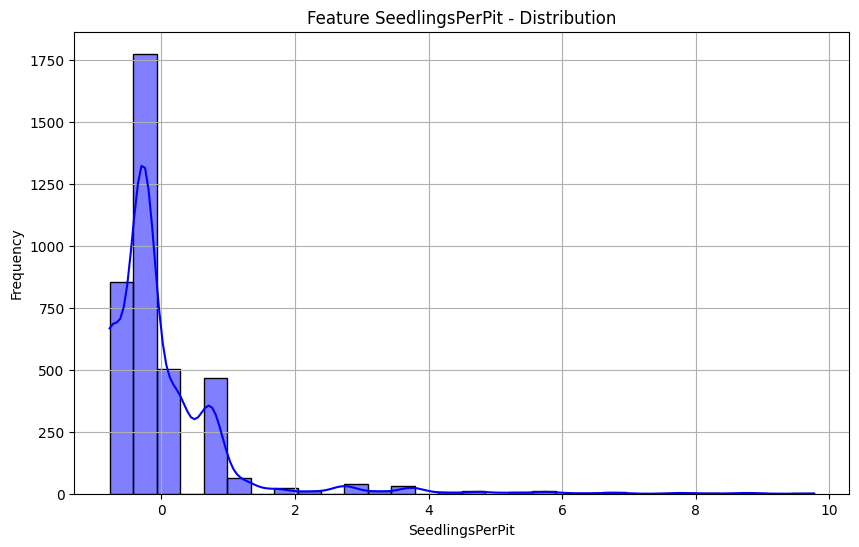

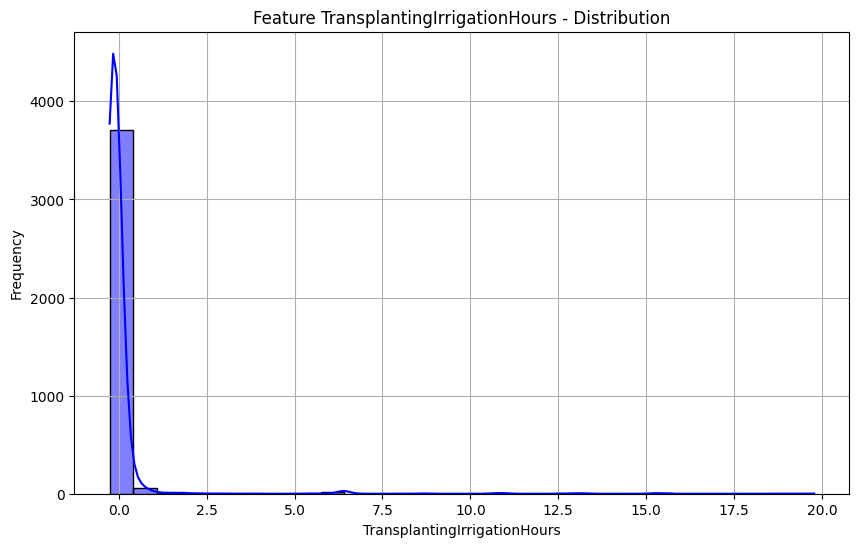

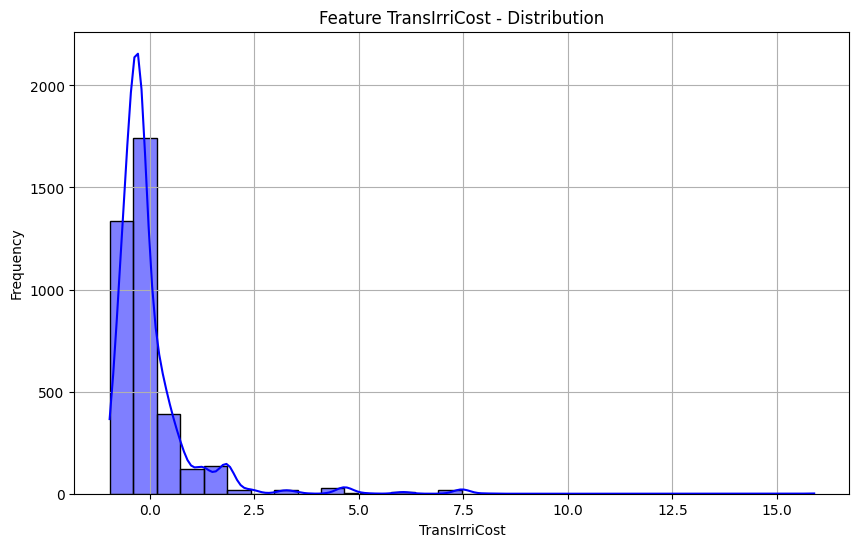

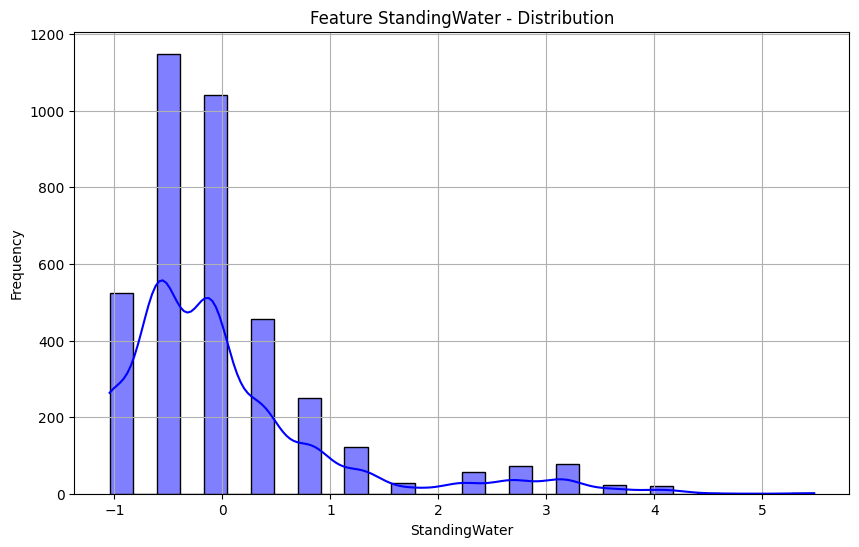

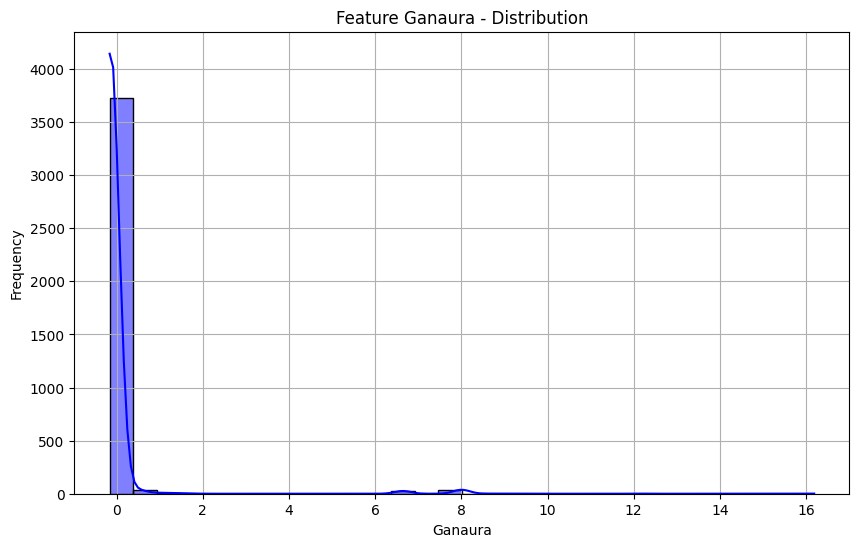

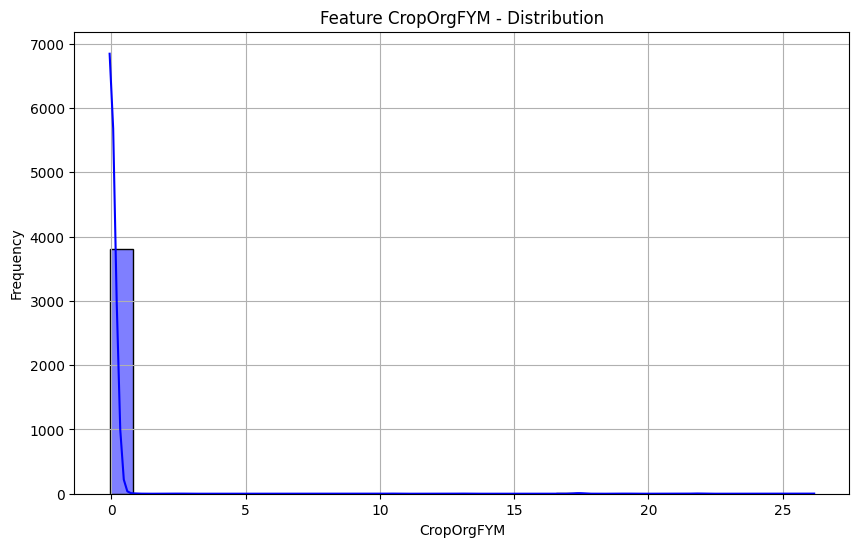

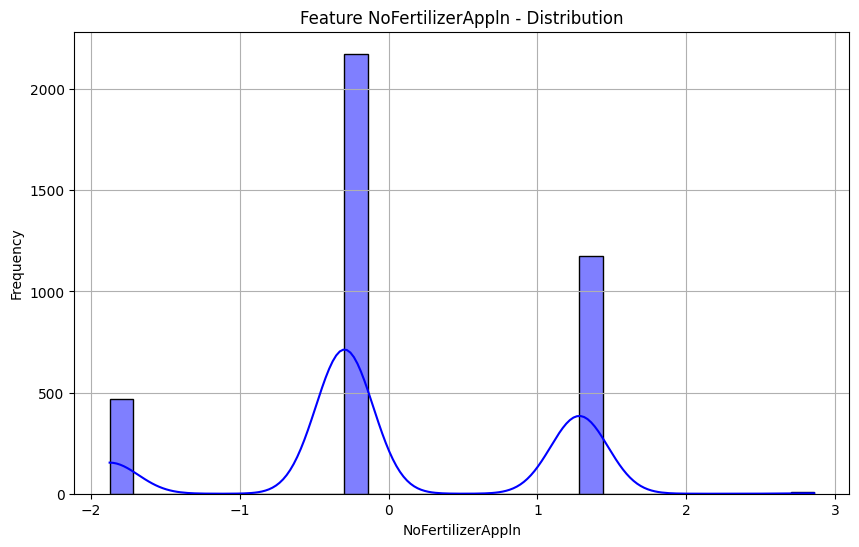

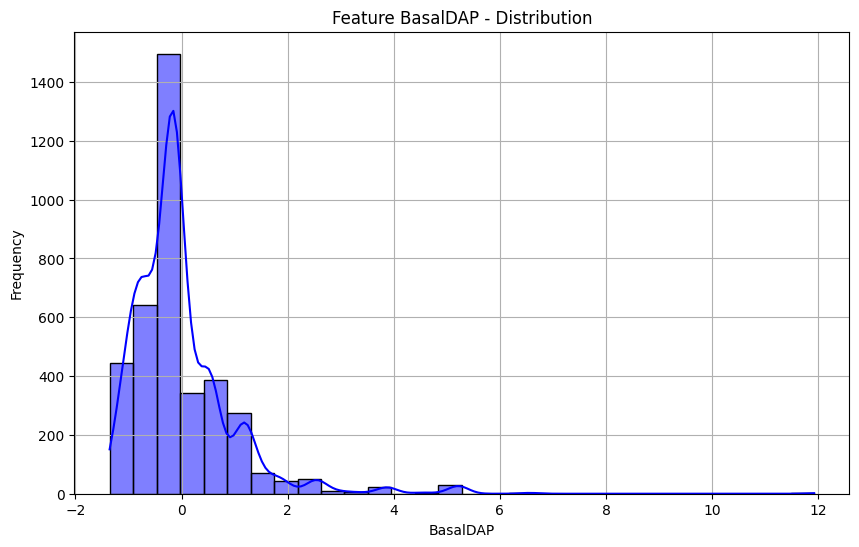

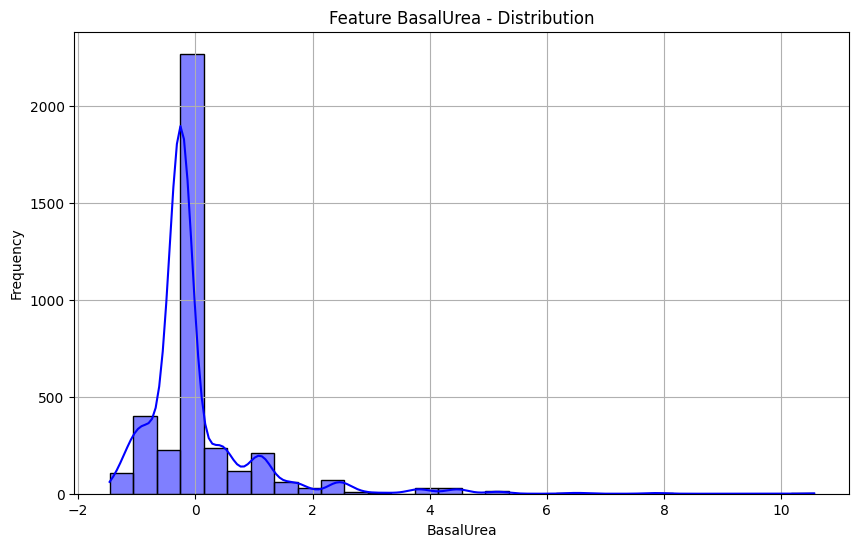

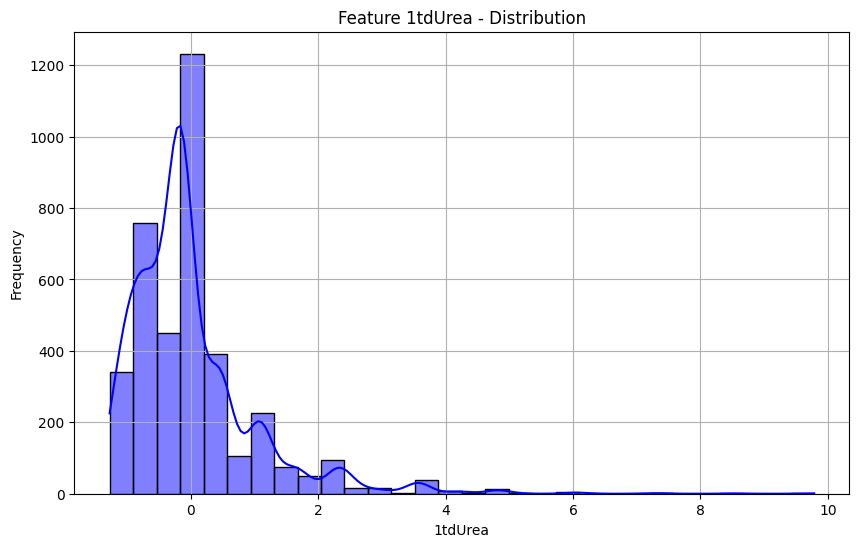

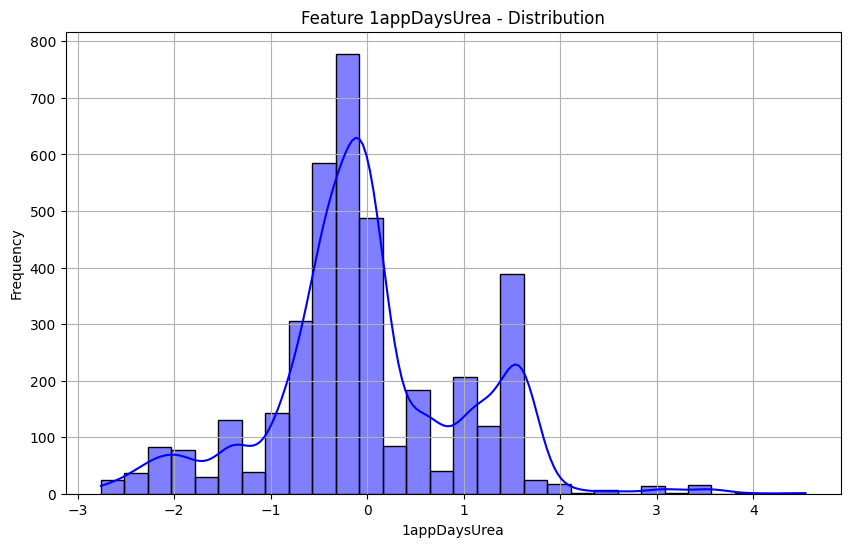

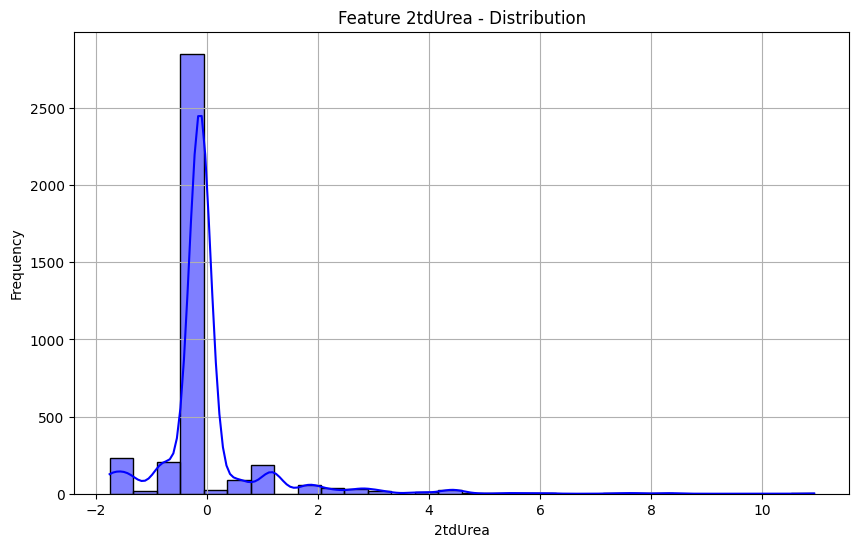

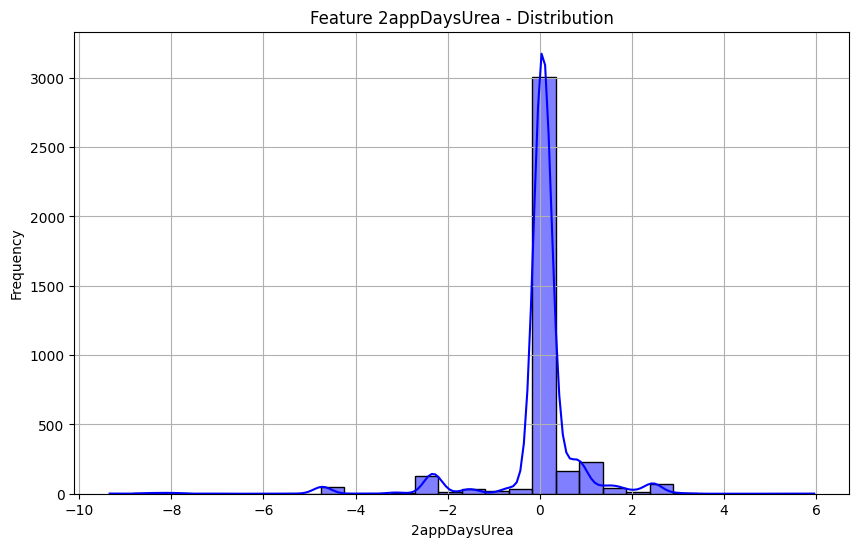

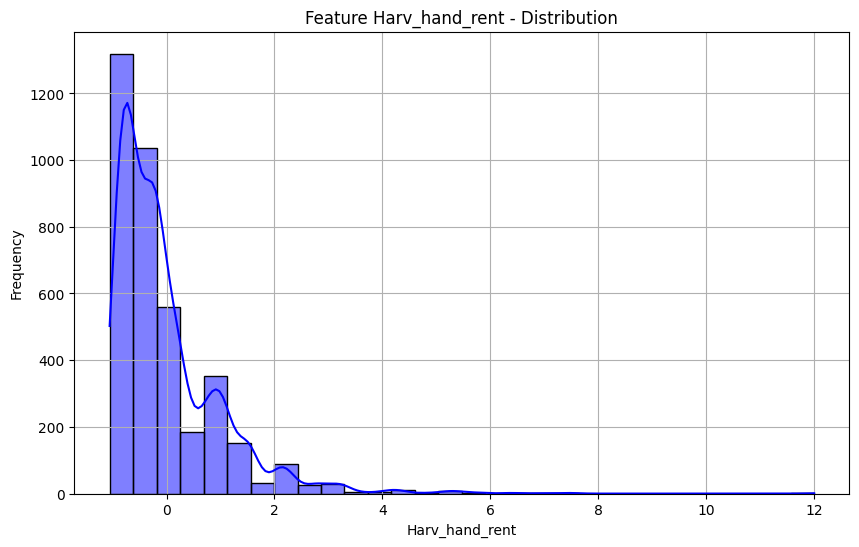

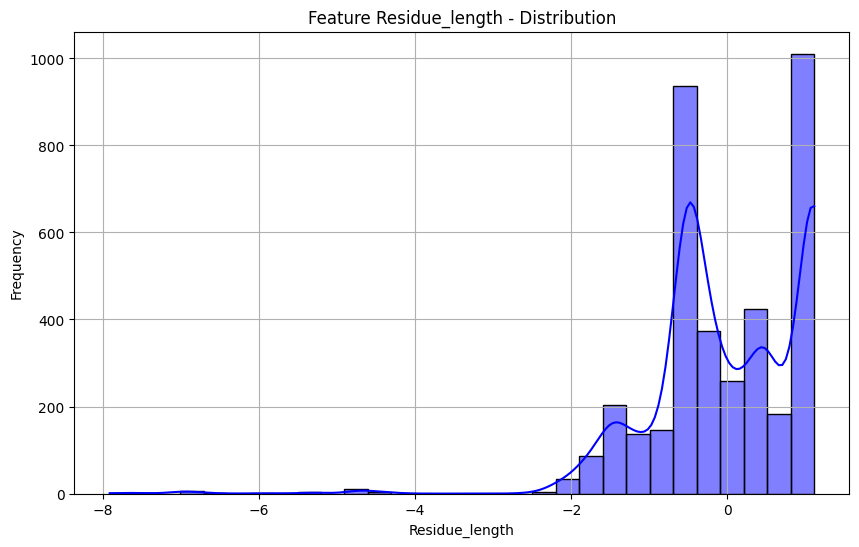

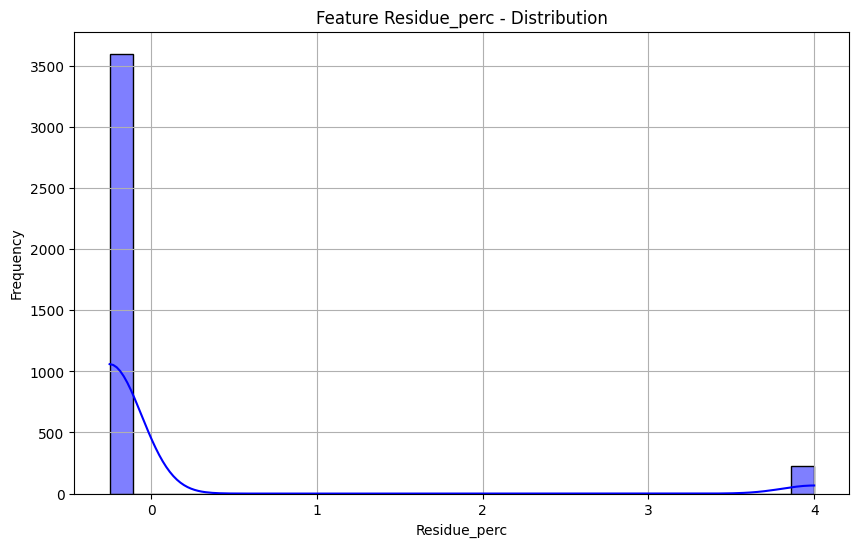

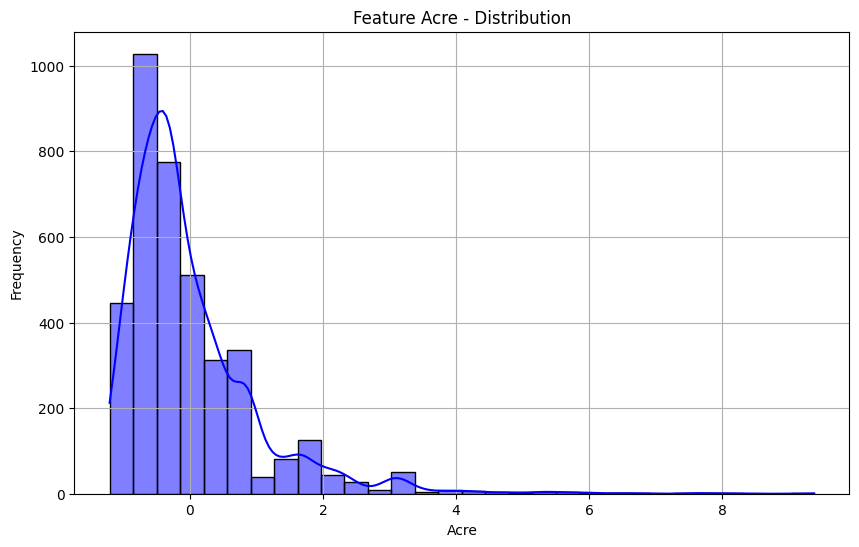

Plotting correlation matrix...


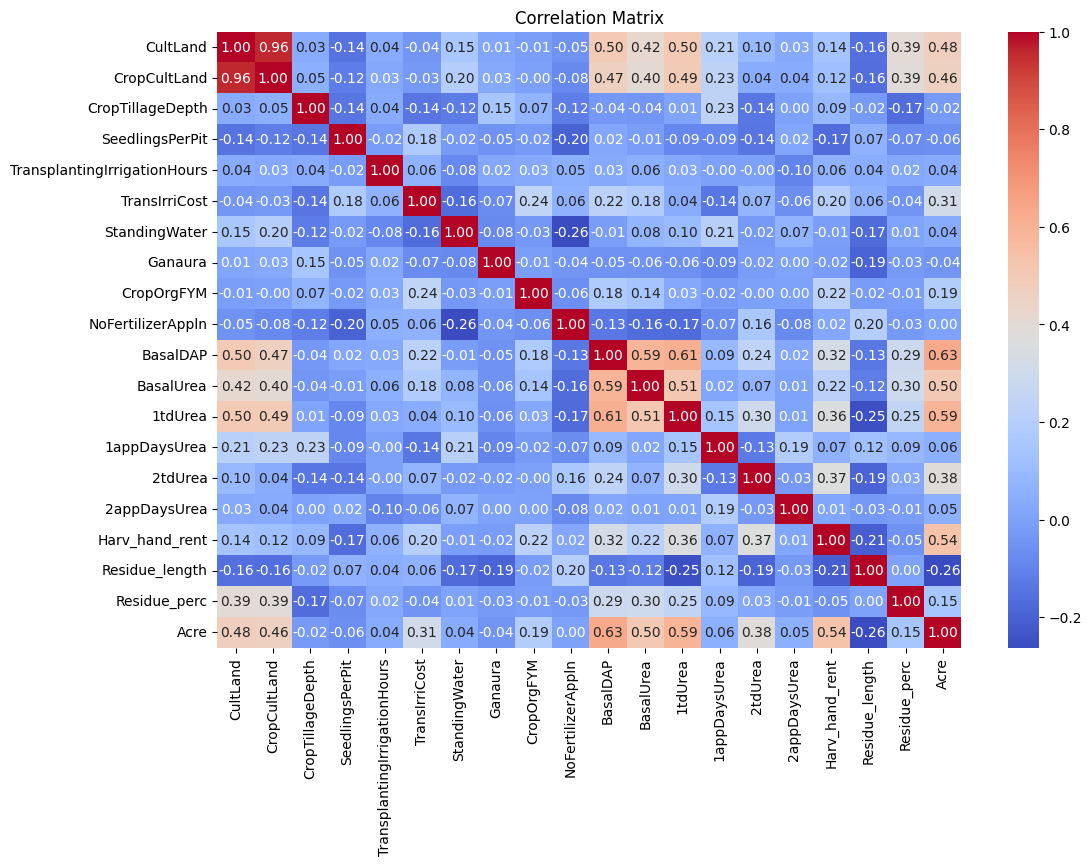

In [14]:
corr = analyze_distributions_and_correlation(all_data_scaled)

In [15]:
def remove_highly_correlated_features(data, correlation_threshold=0.5):
    """
    Removes one feature from each pair of highly correlated features.

    Parameters:
    - data: pd.DataFrame - The dataset to analyze and process.
    - correlation_threshold: float - The threshold above which features are considered highly correlated.

    Returns:
    - pd.DataFrame - Dataset with highly correlated features removed.
    """
   
    corr_matrix = data.corr().abs()

    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    features_to_drop = [
        column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)
    ]
    
    reduced_data = data.drop(columns=features_to_drop)

    return reduced_data, features_to_drop


all_data_reduced, dropped_features = remove_highly_correlated_features(all_data_scaled)


In [16]:
from scipy.stats import boxcox

def transform_features(data):
    """
    Applies feature transformations (e.g., log, Box-Cox) to improve data distribution.

    Parameters:
    - data: pd.DataFrame - The dataset to process.

    Returns:
    - pd.DataFrame - Transformed dataset.
    - dict - Details of transformations applied to each feature.
    """
    transformed_data = data.copy()
    transformations = {}
    
    for column in data.columns:
        skewness = data[column].skew()
        kurtosis = data[column].kurt()

        # Apply transformations based on skewness and kurtosis thresholds
        if skewness > 1 or kurtosis > 10:  # Strongly positive skew or high kurtosis
            # Log transformation (adding 1 to avoid log(0))
            transformed_data[column] = np.log1p(data[column] - data[column].min() + 1)
            transformations[column] = {"Transformation": "Log", "Skewness": skewness, "Kurtosis": kurtosis}
        elif skewness < -1:  # Strongly negative skew
            # Box-Cox transformation (requires positive values)
            positive_data = data[column] - data[column].min() + 1  # Shift to positive
            transformed_data[column], _ = boxcox(positive_data)
            transformations[column] = {"Transformation": "Box-Cox", "Skewness": skewness, "Kurtosis": kurtosis}
        else:
            # No transformation applied
            transformations[column] = {"Transformation": "None", "Skewness": skewness, "Kurtosis": kurtosis}
    
    return transformed_data, transformations


try:
    transformed_data, transformation_details = transform_features(all_data_reduced)
except Exception as e:
    print(f"An error occurred: {e}")

Plotting distributions for each feature...


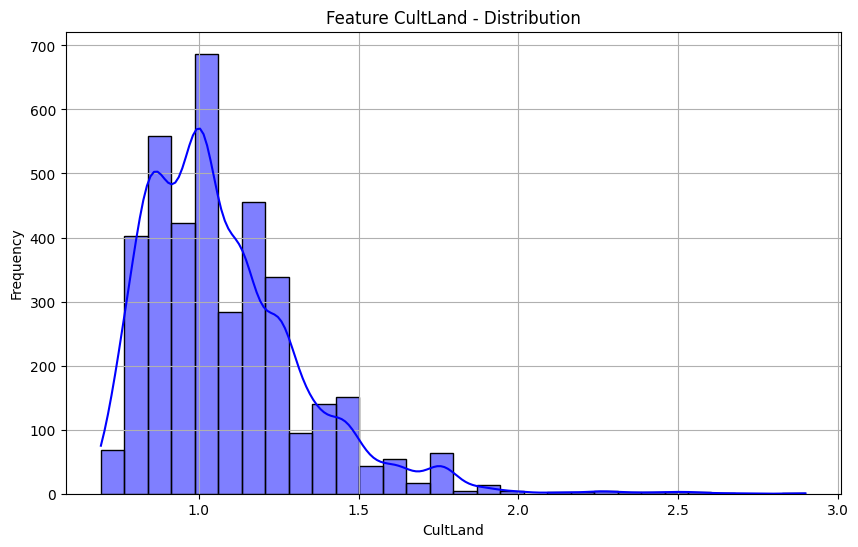

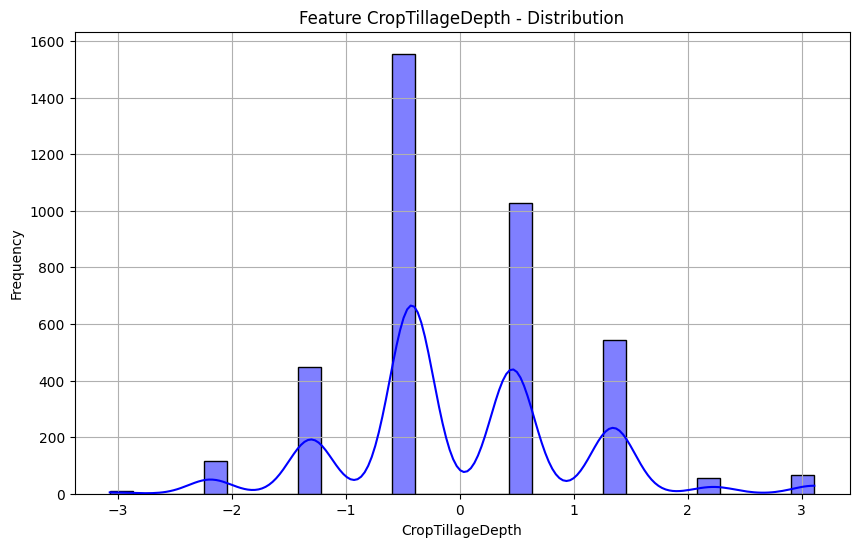

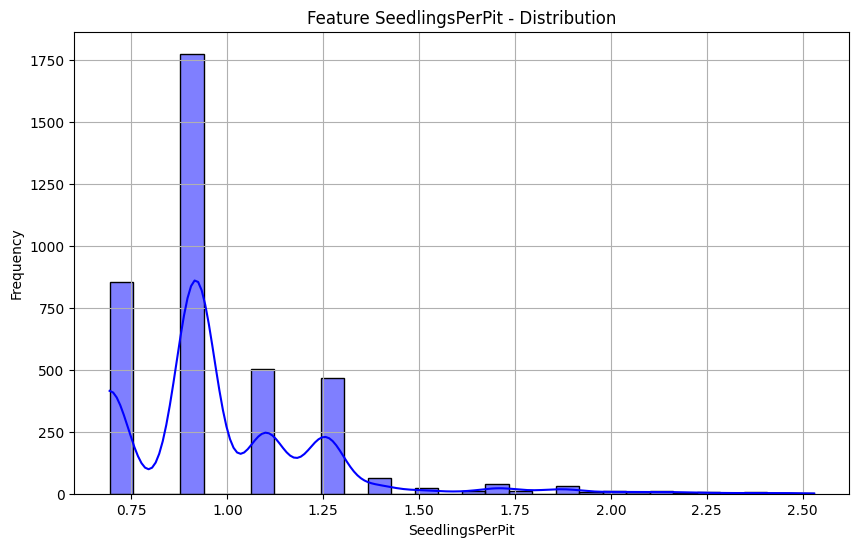

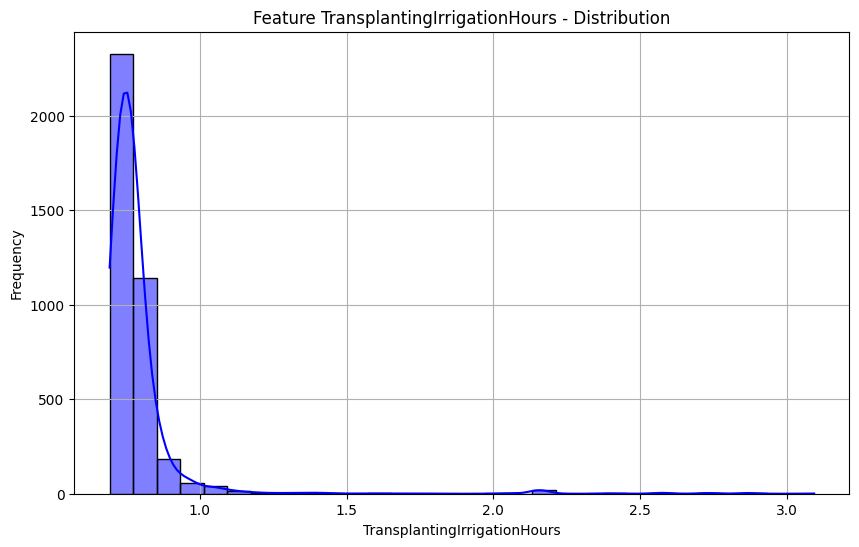

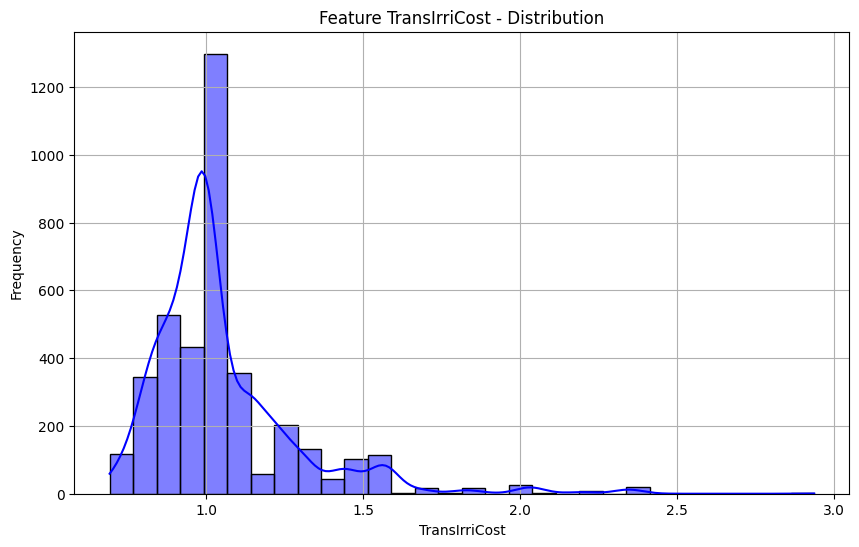

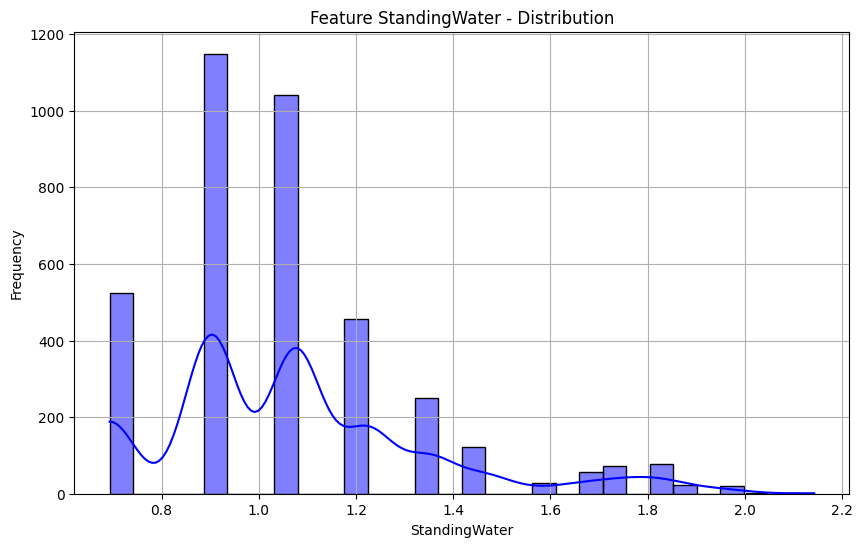

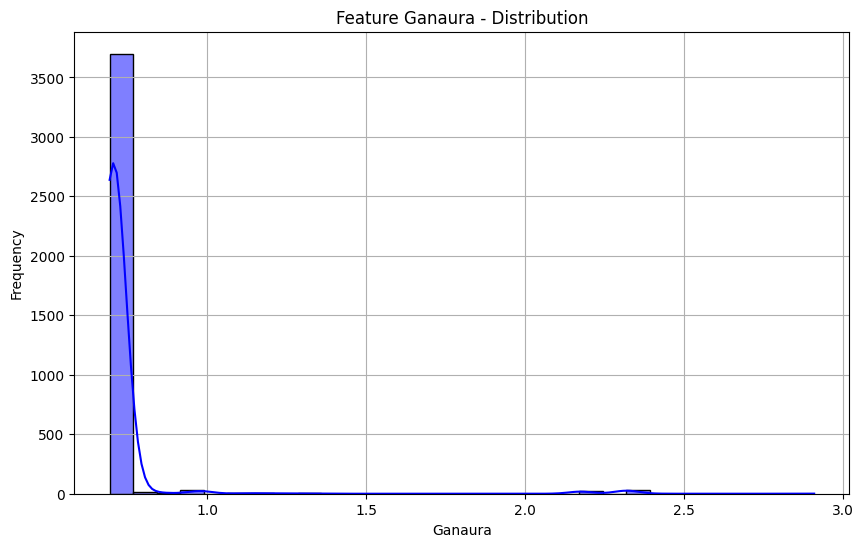

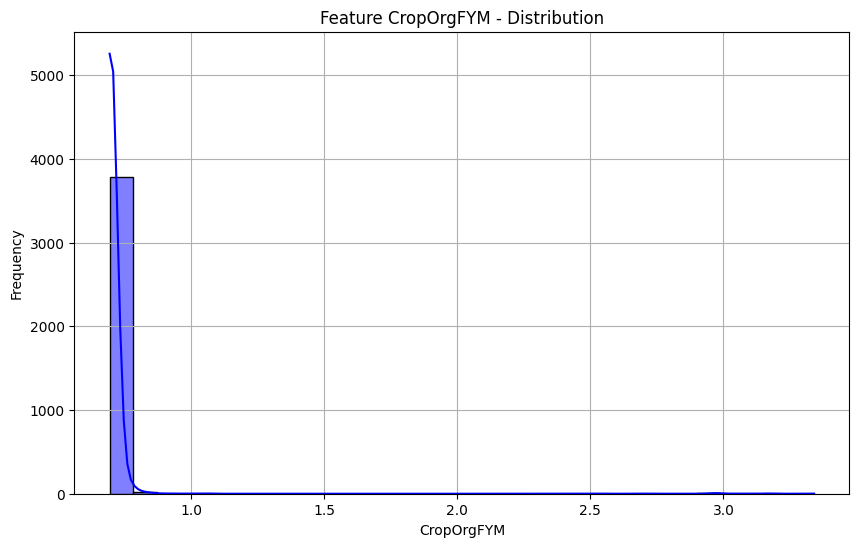

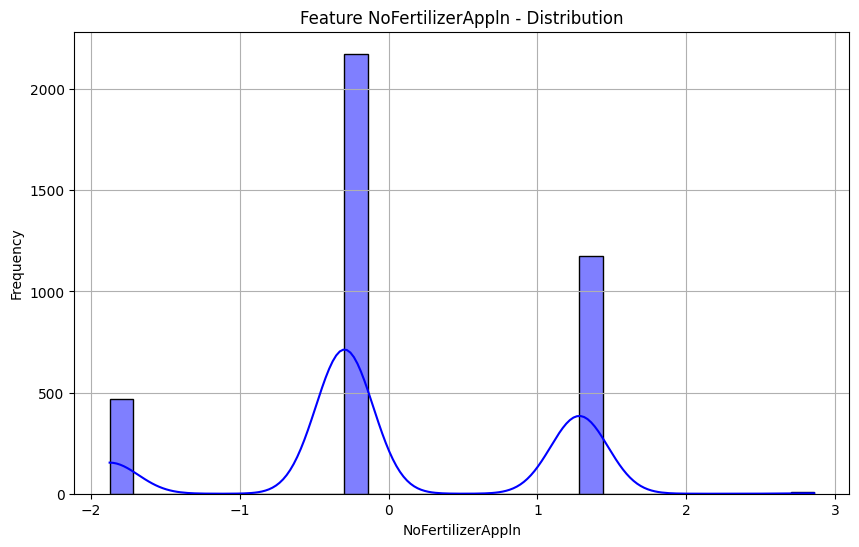

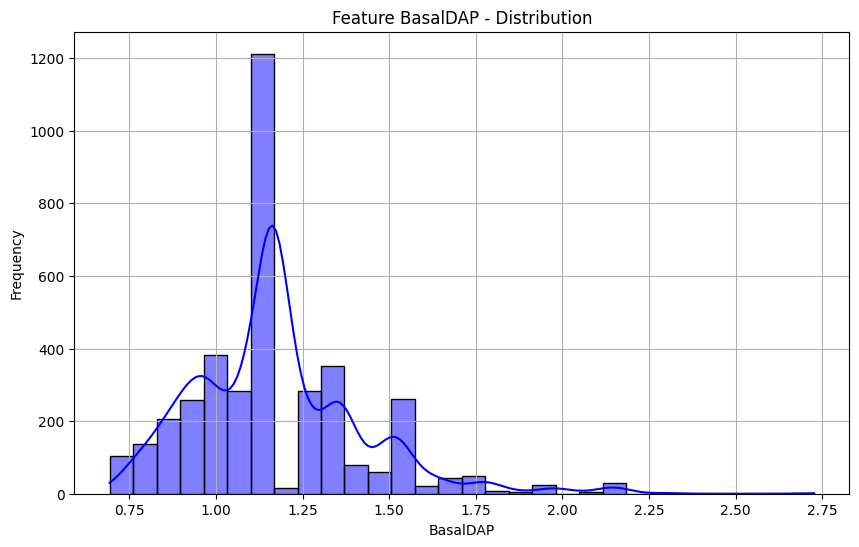

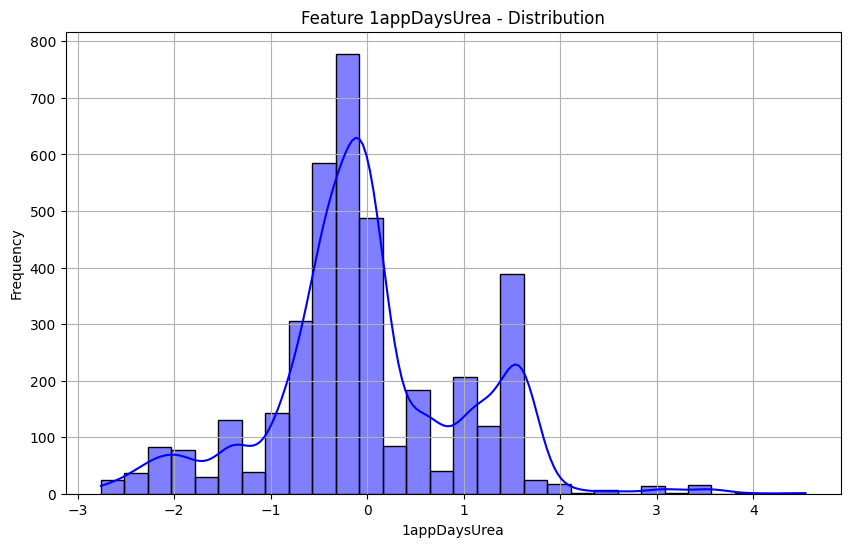

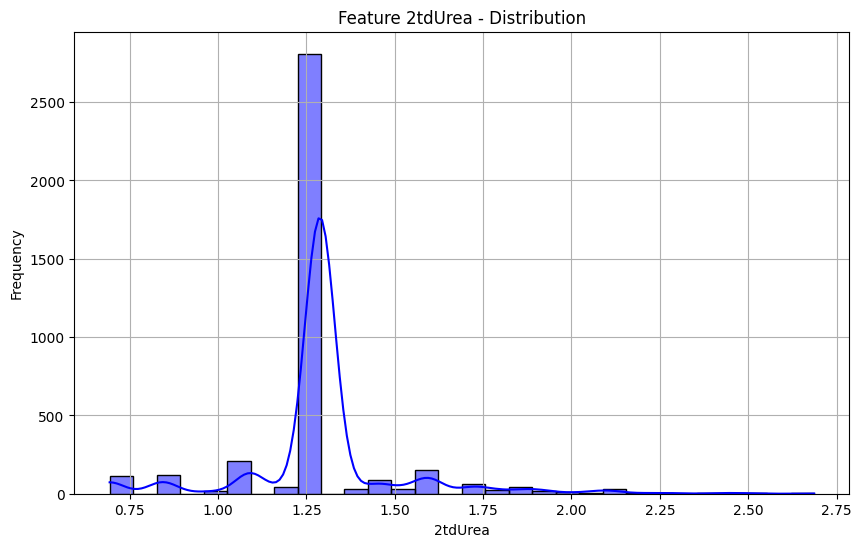

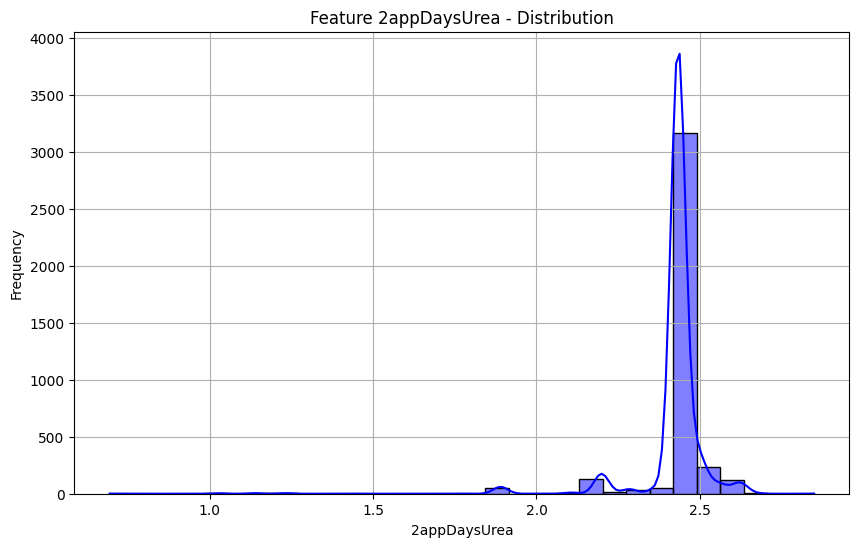

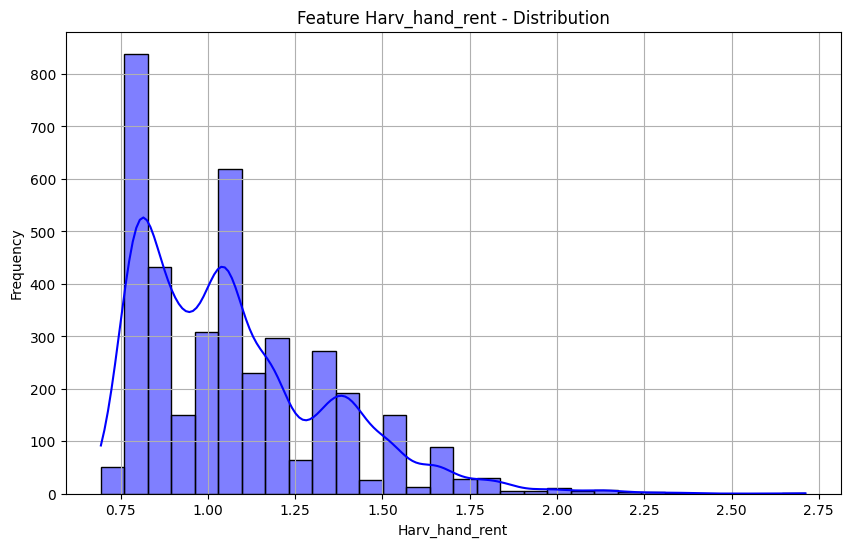

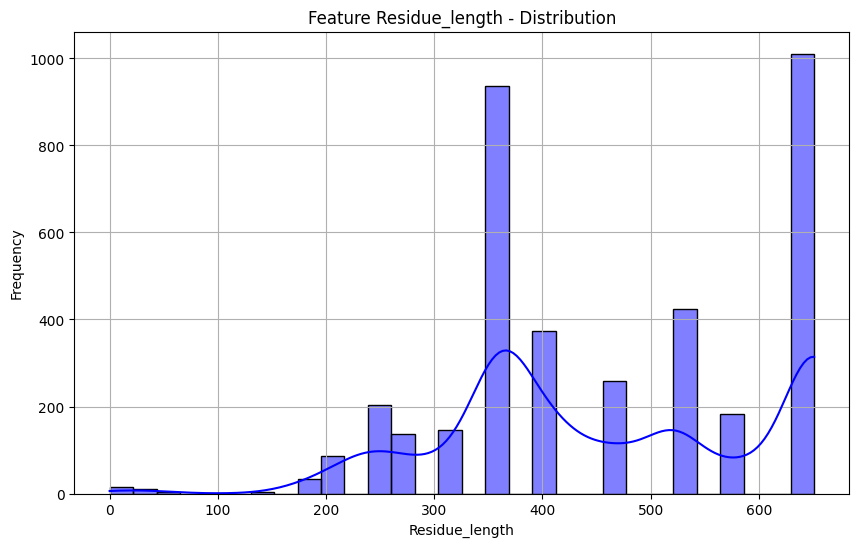

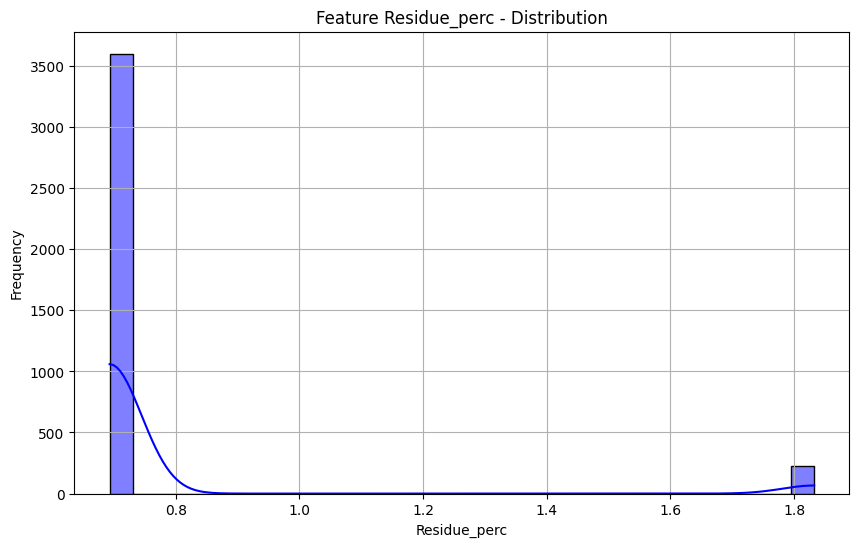

Plotting correlation matrix...


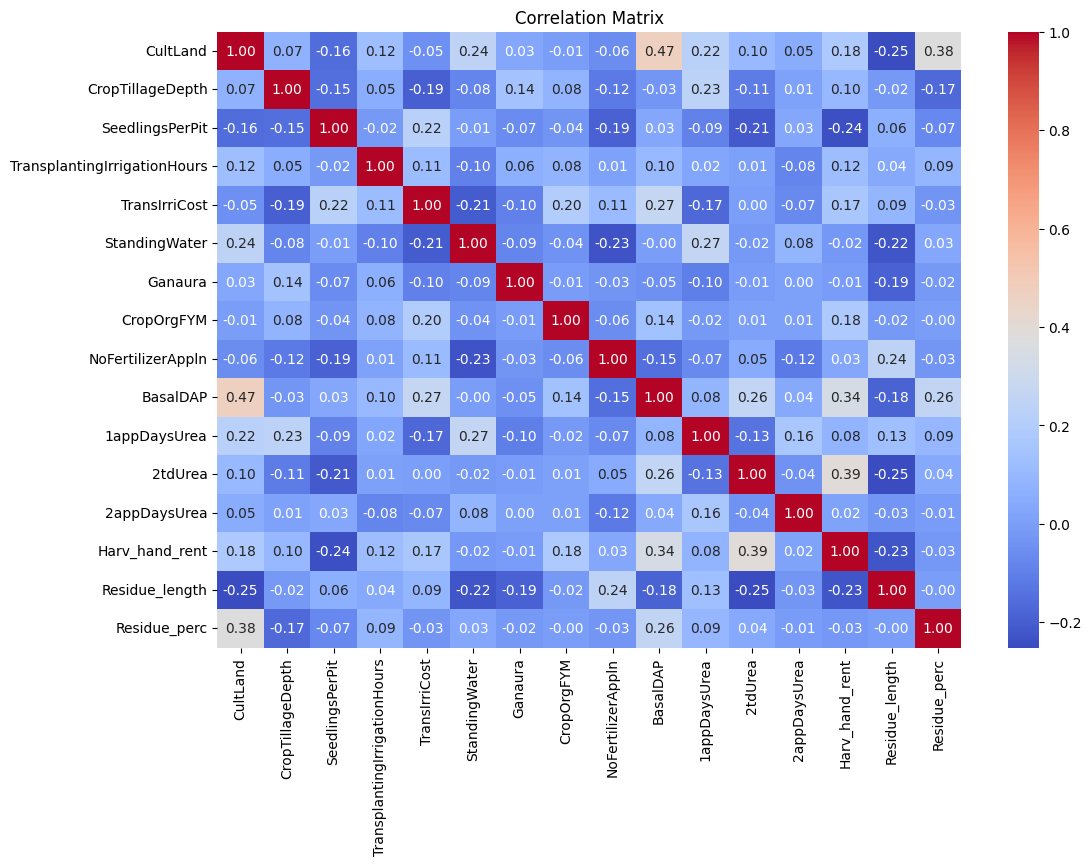

In [17]:
corr1 = analyze_distributions_and_correlation(transformed_data)

In [18]:
from sklearn.model_selection import train_test_split

train_data, test_data, y_train, y_test = train_test_split(transformed_data, y, test_size=0.1, random_state=42)
train_data, val_data, y_train, y_val = train_test_split(train_data, y_train, test_size=2./9, random_state=42) 

train_reduced = train_data.select_dtypes(include=['number'])
val_reduced = val_data.select_dtypes(include=['number'])
test_reduced = test_data.select_dtypes(include=['number'])

train = train_data
val = val_data
test = test_data

ValueError: Found input variables with inconsistent numbers of samples: [3824, 2663]

In [ ]:
custom_model = LinearRegressionElasticNet(
    max_steps=10000,
    alpha=1e-3,      
    l1_ratio=0.005,  
    lam=1e-2        
)

custom_model.fit(train_reduced, y_train)


y_pred = custom_model.predict(test_reduced)
report_df = regression_report(y_test, y_pred)
report_df